# Libraries

In [ ]:
import csv
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from scipy.stats import wilcoxon
from collections import OrderedDict
import pickle
import plotly.express as px
from csv import DictWriter
from matplotlib_venn import venn2, venn2_circles
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import gc
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import matthews_corrcoef
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from numpy import asarray,savez_compressed
pd.set_option("display.max_rows", None, "display.max_columns", None)
!pip install -q SentencePiece transformers
from transformers import AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup, T5EncoderModel, T5Tokenizer
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.nn.utils.rnn import pad_sequence
import requests
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
#from torch.utils import data
import re
import os
!pip install Biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.2 MB/s eta 0:00:00


# Functions

In [ ]:
class Classifier2L(nn.Module):
    def __init__(self, hidden, hidden2, dropout=0):
        super(Classifier2L, self).__init__()
        self.hidden = hidden
        self.hidden2 = hidden2
        self.num_feature = 2200
        self.dropout = dropout
        self.batchnorm1 = nn.BatchNorm1d(self.hidden)
        self.batchnorm2 = nn.BatchNorm1d(self.hidden2)

        self.layer_1 = nn.Linear(self.num_feature,  self.hidden)
        self.layer_2 = nn.Linear( self.hidden, self.hidden2)
        self.layer_3 = nn.Linear( self.hidden2, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x= self.dropout(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x= self.dropout(x)

        x = self.layer_3(x)
        #x = self.sigmoid(x)

        return x


    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
def notNaN(num):
    return num == num

In [ ]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [ ]:
# implementation of a single training epoch
def train_epoch_cross(net, loader, loss_fn, optimizer, scheduler):

    # set the network in training mode
    net.train()

    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct = 0
    targets = []
    predictions = []

    for i, data in enumerate(loader):

        # sample data
        x, y = data
        x = x.to(device)
        y = y.to(device)

        # set all gradients equal to zero
        net.zero_grad()

        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        #y_pred_sq = np.squeeze(y_pred) # add when using loss_fn: BCEloss()

        pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        #correct_tensor = pred.eq(y.float().view_as(pred))
        #correct = np.squeeze(correct_tensor.cpu().numpy())
        #num_correct += np.sum(correct)
        targets.extend(y.cpu().detach().numpy().tolist())
        predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

        #predictions_round = [round(p) for p in predictions]
        #correct_tensor = predictions_round.eq(targets.float().view_as(predictions_round))

        #loss = loss_fn(y_pred_sq, y.float())  #add when using loss_fn: BCEloss()
        loss = loss_fn(y_pred, y.float())

        # Specify L1 and L2 weights
        l1_weight = 0
        l2_weight = 0

        # Compute L1 and L2 loss component
        parameters = []
        for parameter in net.parameters():
            parameters.append(parameter.view(-1))
        l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))

        # Add L1 and L2 loss components
        loss += l1
        loss += l2

        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
        scheduler.step()

        #break #for training one batch

    # compute the average loss
    #mytrain_acc = num_correct
    loss_avg = loss_cum / cnt

    #predictions = np.array(predictions) >= 0.5
    predictions = [1 if p[0] > 0.5 else 0 for p in predictions]
    mytrain_acc  = metrics.accuracy_score(targets, predictions)   *100
    #mytrain_acc = (num_correct/ (len(y)*cnt)) *100
    return loss_avg, mytrain_acc

def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

In [ ]:
# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):

    # set the network in evaluation mode
    net.eval()

    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct_val = 0
    targets = []
    predictions = []
    with torch.no_grad():
      for i, data in enumerate(loader):

          x, y = data
          x = x.to(device)
          y = y.to(device)

          # feed the batch to the network and compute the outputs
          y_pred = net(x.float())
          #y_pred_sq = np.squeeze(y_pred) #add when using loss_fn: BCEloss()
          pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer

          # compare predictions to true label
          #correct_tensor = pred.eq(y.float().view_as(pred))
          #correct = np.squeeze(correct_tensor.cpu().numpy())

          targets.extend(y.cpu().detach().numpy().tolist())
          predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

          #num_correct_val += np.sum(correct)
          # compare the outputs to the labels with the loss function
          #loss = loss_fn(y_pred_sq, y.float())  #ad|d when using loss_fn: BCEloss()
          loss = loss_fn(y_pred, y.float())

          # Specify L1 and L2 weights
          l1_weight = 0
          l2_weight = 0

          # Compute L1 and L2 loss component
          parameters = []
          for parameter in net.parameters():
              parameters.append(parameter.view(-1))
          l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
          l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))

          # Add L1 and L2 loss components
          loss += l1
          loss += l2

          loss_cum += loss.data.cpu().numpy()
          cnt += 1

    # compute the average loss
    loss_avg = loss_cum / cnt
    predictions = np.array(predictions) >= 0.5
    mytest_acc  = (metrics.accuracy_score(targets, predictions)) *100
    total = cnt *len(y)

    return loss_avg, mytest_acc

In [ ]:
def train_net_cross(net, train_loader, val_loader, loss_fn, optimizer, epochs , scheduler):

    # transfer the network to the GPU
    net = net.to(device)

    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    train_acc_alt = np.zeros((epochs))

    test_acc = np.zeros((epochs))
    test_acc_alt = np.zeros((epochs))

    print("Begin training.")

    for epoch in tqdm(range(epochs)):

        # training
        train_loss[epoch], train_acc[epoch] = train_epoch_cross(net, train_loader, loss_fn, optimizer, scheduler)
        # validation
        test_loss[epoch], test_acc[epoch] = test_epoch(net, val_loader, loss_fn)

        print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f'
             % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

        #print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f'
        #    % (epoch, train_loss[epoch], train_acc[epoch]))# for training one batch

    return (train_loss, test_loss), (train_acc , test_acc)
    #return train_loss, train_acc # for training one batch

In [ ]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })

DWithInd = dataset_with_indices(torch.utils.data.TensorDataset)

In [ ]:
def Average(lst):
  return sum(lst) /len(lst)

In [ ]:
def get_class_distribution_binary(obj):
    count_dict = {
        'Neutral': 0,
        'Deleterious': 0,
    }

    for i in obj:
        if i == 0:
            count_dict['Neutral'] += 1
        elif i == 1:
            count_dict['Deleterious'] += 1

        else:
            print("Check classes.")

    return count_dict

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc

In [ ]:
class ClassifierDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [ ]:
def unique(list1):

    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    print(f'{len(unique_list)} unique transcripts')
    return unique_list

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        #nn.init.normal_(m.weight, std=0.01)
        nn.init.xavier_normal_(m.weight)

    if type(m) == nn.LSTM:
      for param in m._flat_weights_names:
          if "weight" in param:
              nn.init.xavier_uniform_(m._parameters[param])

# Import training set

In [ ]:
# import difference for each mutation + labels
# File found in Datasets found in Zenodo repository
dif_mut = pd.read_csv('log_probWT_MUT_Tier1_2_3_common_balanced+-2_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut[dif_mut['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut[dif_mut['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut['fl_dif_pad'] = fl_dif_pad

#dif_mut_shuffled = dif_mut.sample(frac=1)
dif_mut_shuffled = dif_mut
stacked_flat =[]
for i, mut in dif_mut_shuffled.iterrows():
  stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

stacked_gmm = torch.stack(stacked_flat)
print(stacked_gmm.shape)

Deleterious mutations in dataset:  2956
Benign mutations in dataset:  3652
torch.Size([6608, 2200])


# with validation to find early stopping

Text(0.5, 1.0, 'Class Distribution in Val Set')

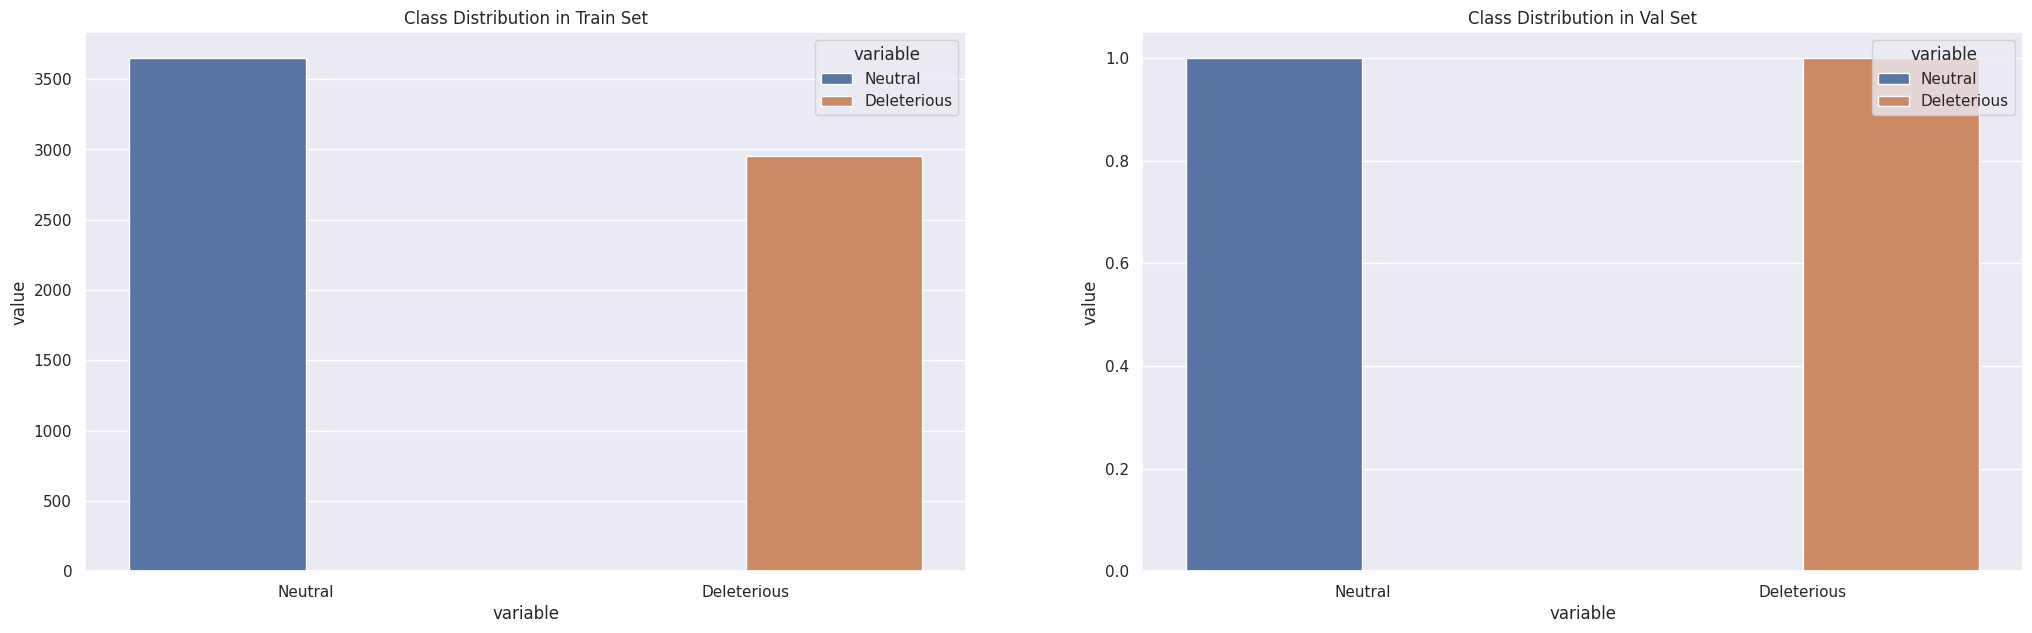

In [ ]:
temp = dif_mut_shuffled.mutation.str.split(pat='_',expand=True)
# seperate inputs and outputs
X = stacked_gmm
y = dif_mut_shuffled['label']

# Split, shuffle and stratify sequences, mutations, proteins and label
#X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, temp[1],  temp[0], test_size=0.1, stratify=y, random_state=69)
X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, temp[1],  temp[0], test_size=0.0002, stratify=y, random_state=69) #balance_ccommo
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

#del stacked_gmm, X
gc.collect()

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.737622 - Train accuracy: 57.569782 - Test loss: 0.647375 - Test accuracy: 50.000000
Epoch     1 - Train loss: 0.609030 - Train accuracy: 70.524879 - Test loss: 0.648539 - Test accuracy: 50.000000
Epoch     2 - Train loss: 0.589291 - Train accuracy: 71.814320 - Test loss: 0.630739 - Test accuracy: 50.000000
Epoch     3 - Train loss: 0.572645 - Train accuracy: 71.996359 - Test loss: 0.611729 - Test accuracy: 50.000000
Epoch     4 - Train loss: 0.544366 - Train accuracy: 73.725728 - Test loss: 0.570726 - Test accuracy: 50.000000
Epoch     5 - Train loss: 0.530958 - Train accuracy: 74.893811 - Test loss: 0.595318 - Test accuracy: 50.000000
Epoch     6 - Train loss: 0.504782 - Train accuracy: 76.107403 - Test loss: 0.579864 - Test accuracy: 50.000000
Epoch     7 - Train loss: 0.485578 - Train accuracy: 77.184466 - Test loss: 0.531981 - Test accuracy: 50.000000
Epoch     8 - Train loss: 0.466681 - Train accuracy: 78.549757 - Test loss: 0.535307 - Test accuracy: 50

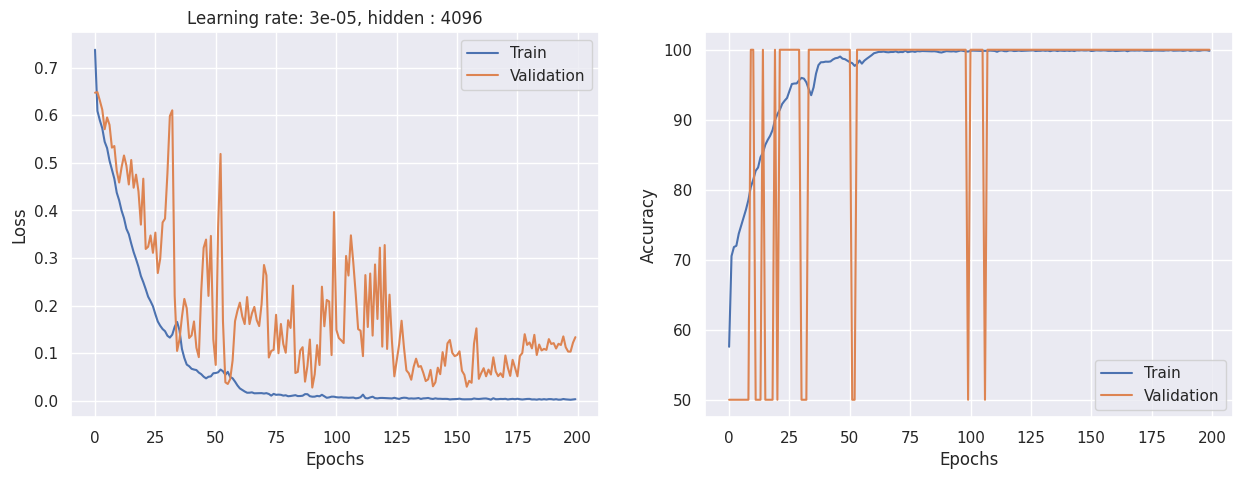

In [ ]:
BATCH_SIZE=64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=2, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs =200
lr = 3e-5
#h = 1024
#h = 2048
h = 4096
#h= 8192
#hidden2 =258
#hidden2=1024
hidden2=2048
#hidden2=4096

my_net = Classifier2L(h, hidden2, 0.3).to(device)
#my_net = Classifier(h, 0.3).to(device)
my_net.apply(init_weights)
param_optimizer = list(my_net.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.02,
    },
]

num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
optimizer = torch.optim.AdamW(optimizer_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=1000, num_training_steps=num_train_steps
)
#loss_fn = nn.BCELoss()

loss, acc = train_net_cross(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler)

plt.rcParams["figure.figsize"] = (15,5)
sns.set()
# plot train/validation loss curves
plt.subplot(1, 2, 1)
plt.plot(loss[0])
plt.plot(loss[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Learning rate: {lr}, hidden : {h}')
plt.legend(('Train', 'Validation'))
#plt.title(f'Learning rate: {lr}, hidden : {h}, hidden2: {h2}')

plt.subplot(1, 2, 2)
plt.plot(acc[0])
plt.plot(acc[1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

In [ ]:
# RUN ONCE
#torch.save(my_net.state_dict(), '/content/drive/MyDrive/my_colab/3rdYear/GMM/model')

# Cross-validation DRGN

In [ ]:
# import difference for each mutation + labels
dif_mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_common_balanced+-2_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# exclude duplicates
#dif_mut.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut[dif_mut['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut[dif_mut['label'] == 0]))


# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut['fl_dif_pad'] = fl_dif_pad
dif_mut_shuffled = dif_mut.sample(frac=1)

Deleterious mutations in dataset:  2956
Benign mutations in dataset:  3652


In [ ]:
dif_mut_drgn = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_DRGN_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
# exclude duplicates
#dif_mut_drgn.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn[dif_mut_drgn['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

dif_mut_drgn_shuffled = dif_mut_drgn.sample(frac=1)

Deleterious mutations in dataset:  1695
Benign mutations in dataset:  1908


In [ ]:
# implementation of a single training epoch
def train_epoch_cross(net, loader, loss_fn, optimizer, scheduler):

    # set the network in training mode
    net.train()

    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct = 0
    targets = []
    predictions = []

    for i, data in enumerate(loader):

        # sample data
        x, y = data
        x = x.to(device)
        y = y.to(device)

        # set all gradients equal to zero
        net.zero_grad()

        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        #y_pred_sq = np.squeeze(y_pred) # add when using loss_fn: BCEloss()

        pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        #correct_tensor = pred.eq(y.float().view_as(pred))
        #correct = np.squeeze(correct_tensor.cpu().numpy())
        #num_correct += np.sum(correct)
        targets.extend(y.cpu().detach().numpy().tolist())
        predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

        #predictions_round = [round(p) for p in predictions]
        #correct_tensor = predictions_round.eq(targets.float().view_as(predictions_round))

        #loss = loss_fn(y_pred_sq, y.float())  #add when using loss_fn: BCEloss()
        loss = loss_fn(y_pred, y.float())

        # Specify L1 and L2 weights
        l1_weight = 0
        l2_weight = 0

        # Compute L1 and L2 loss component
        parameters = []
        for parameter in net.parameters():
            parameters.append(parameter.view(-1))
        l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))

        # Add L1 and L2 loss components
        loss += l1
        loss += l2

        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
        scheduler.step()

        #break #for training one batch

    # compute the average loss
    #mytrain_acc = num_correct
    loss_avg = loss_cum / cnt

    #predictions = np.array(predictions) >= 0.5
    predictions = [1 if p[0] > 0.5 else 0 for p in predictions]
    mytrain_acc  = metrics.accuracy_score(targets, predictions)   *100
    #mytrain_acc = (num_correct/ (len(y)*cnt)) *100
    return loss_avg, mytrain_acc

def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

In [ ]:
def train_net_cross(net, train_loader, val_loader, loss_fn, optimizer, epochs , scheduler):

    # transfer the network to the GPU
    net = net.to(device)

    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    train_acc_alt = np.zeros((epochs))

    test_acc = np.zeros((epochs))
    test_acc_alt = np.zeros((epochs))

    print("Begin training.")

    for epoch in tqdm(range(epochs)):

        # training
        train_loss[epoch], train_acc[epoch] = train_epoch_cross(net, train_loader, loss_fn, optimizer, scheduler)
        #predictions, outputs = eval(net, train_loader)
        #train_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)

        # validation
        test_loss[epoch], test_acc[epoch] = test_epoch(net, val_loader, loss_fn)
        #predictions, outputs = eval(net, val_loader)
        #test_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)

        #print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f'
        #     % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

        #print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f'
        #    % (epoch, train_loss[epoch], train_acc[epoch]))# for training one batch

    return (train_loss, test_loss), (train_acc , test_acc)
    #return train_loss, train_acc # for training one batch

torch.Size([721, 2200])
torch.Size([6343, 2200])
Proteins in common between training set / test set:  121
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.66      0.55      0.60       391
           1       0.56      0.67      0.61       330

    accuracy                           0.60       721
   macro avg       0.61      0.61      0.60       721
weighted avg       0.61      0.60      0.60       721

221 215 176 109
Sensitivity: 66.97
Specificity: 54.99
0.21991193351190114


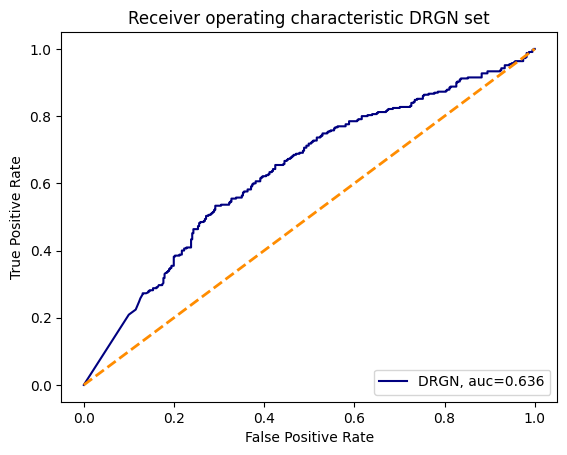

----------
Protein Q6N021 has 5 deleterious and 6 benign samples in training set of 0 Fold 
Protein Q6N021 has 0 deleterious and 3 benign samples in test set of 0 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P40337 has 10 deleterious and 7 benign samples in training set of 0 Fold 
Protein P40337 has 8 deleterious and 13 benign samples in test set of 0 Fold 
Samples for Protein:  21
Precision: 0.47619047619047616
Recall: 0.47619047619047616
F-measure: 0.47619047619047616
----------
Protein Q99708 has 1 deleterious and 1 benign samples in training set of 0 Fold 
Protein Q99708 has 0 deleterious and 1 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 0 Fold 
Protein P42338 has 1 deleterious and 0 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precis

<ipython-input-38-91901db5737a>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Groundtruth'] = y_drgn
<ipython-input-38-91901db5737a>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = predictions_drgn


Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P52701 has 9 deleterious and 9 benign samples in training set of 0 Fold 
Protein P52701 has 2 deleterious and 2 benign samples in test set of 0 Fold 
Samples for Protein:  4
Precision: 0.75
Recall: 0.75
F-measure: 0.75
----------
Protein P10721 has 15 deleterious and 13 benign samples in training set of 0 Fold 
Protein P10721 has 12 deleterious and 2 benign samples in test set of 0 Fold 
Samples for Protein:  14
Precision: 0.5714285714285714
Recall: 0.5714285714285714
F-measure: 0.5714285714285714
----------
Protein P43246 has 14 deleterious and 11 benign samples in training set of 0 Fold 
Protein P43246 has 4 deleterious and 5 benign samples in test set of 0 Fold 
Samples for Protein:  9
Precision: 0.8888888888888888
Recall: 0.8888888888888888
F-measure: 0.8888888888888888
----------
Protein O14746 has 7 deleterious and 8 benign samples in training set of 0 Fold 
Protein O14746 has 1 deleterious and 6 benign samples in test 

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.63      0.47      0.54       387
           1       0.53      0.68      0.59       334

    accuracy                           0.57       721
   macro avg       0.58      0.57      0.57       721
weighted avg       0.58      0.57      0.56       721

226 183 204 108
Sensitivity: 67.66
Specificity: 47.29
0.15196113792468352


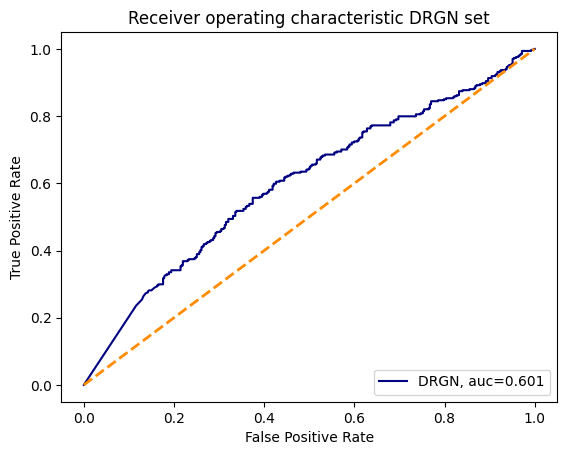

----------
Protein Q6N021 has 5 deleterious and 6 benign samples in training set of 1 Fold 
Protein Q6N021 has 0 deleterious and 1 benign samples in test set of 1 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P40337 has 9 deleterious and 6 benign samples in training set of 1 Fold 
Protein P40337 has 0 deleterious and 18 benign samples in test set of 1 Fold 
Samples for Protein:  18
Precision: 0.3888888888888889
Recall: 0.3888888888888889
F-measure: 0.3888888888888889
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 1 Fold 
Protein P42338 has 2 deleterious and 0 benign samples in test set of 1 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P54278 has 7 deleterious and 7 benign samples in training set of 1 Fold 
Protein P54278 has 1 deleterious and 6 benign samples in test set of 1 Fold 
Samples for Protein:  7
Precision: 0.5714285714285714
Recall: 0.571428571428571

<ipython-input-38-91901db5737a>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Groundtruth'] = y_drgn
<ipython-input-38-91901db5737a>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = predictions_drgn


 6
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P52701 has 8 deleterious and 8 benign samples in training set of 1 Fold 
Protein P52701 has 0 deleterious and 3 benign samples in test set of 1 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P10721 has 15 deleterious and 13 benign samples in training set of 1 Fold 
Protein P10721 has 13 deleterious and 2 benign samples in test set of 1 Fold 
Samples for Protein:  15
Precision: 0.5333333333333333
Recall: 0.5333333333333333
F-measure: 0.5333333333333333
----------
Protein P21802-20 has 0 deleterious and 2 benign samples in training set of 1 Fold 
Protein P21802-20 has 0 deleterious and 1 benign samples in test set of 1 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P43246 has 13 deleterious and 14 benign samples in training set of 1 Fold 
Protein P43246 has 4 deleterious and 4 benign samples in

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.68      0.52      0.59       396
           1       0.54      0.70      0.61       325

    accuracy                           0.60       721
   macro avg       0.61      0.61      0.60       721
weighted avg       0.62      0.60      0.60       721

227 205 191 98
Sensitivity: 69.85
Specificity: 51.77
0.21787708788572296


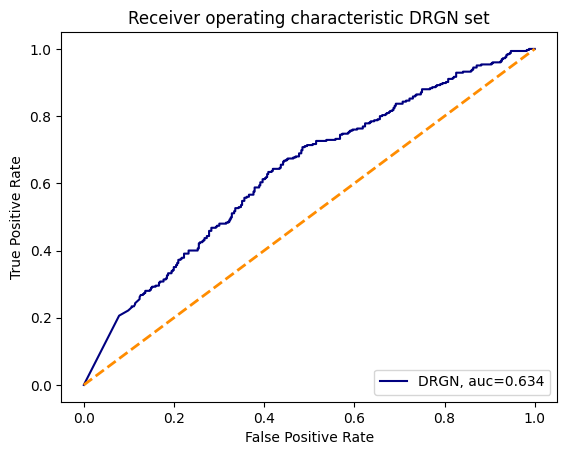

----------
Protein Q6N021 has 5 deleterious and 3 benign samples in training set of 2 Fold 
Protein Q6N021 has 0 deleterious and 5 benign samples in test set of 2 Fold 
Samples for Protein:  5
Precision: 0.6
Recall: 0.6
F-measure: 0.6
----------
Protein P40337 has 9 deleterious and 7 benign samples in training set of 2 Fold 
Protein P40337 has 2 deleterious and 14 benign samples in test set of 2 Fold 
Samples for Protein:  16
Precision: 0.6875
Recall: 0.6875
F-measure: 0.6875
----------
Protein Q99708 has 1 deleterious and 1 benign samples in training set of 2 Fold 
Protein Q99708 has 0 deleterious and 1 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 2 Fold 
Protein P42338 has 1 deleterious and 0 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P54278 has 4 deleterious and 7

<ipython-input-38-91901db5737a>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Groundtruth'] = y_drgn
<ipython-input-38-91901db5737a>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = predictions_drgn


Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P10721 has 15 deleterious and 13 benign samples in training set of 2 Fold 
Protein P10721 has 16 deleterious and 4 benign samples in test set of 2 Fold 
Samples for Protein:  20
Precision: 0.45
Recall: 0.45
F-measure: 0.45
----------
Protein P21802-20 has 0 deleterious and 2 benign samples in training set of 2 Fold 
Protein P21802-20 has 1 deleterious and 1 benign samples in test set of 2 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P43246 has 10 deleterious and 10 benign samples in training set of 2 Fold 
Protein P43246 has 12 deleterious and 6 benign samples in test set of 2 Fold 
Samples for Protein:  18
Precision: 0.6111111111111112
Recall: 0.6111111111111112
F-measure: 0.6111111111111112
----------
Protein O14746 has 5 deleterious and 5 benign samples in training set of 2 Fold 
Protein O14746 has 1 deleterious and 12 benign samples

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       381
           1       0.56      0.67      0.61       340

    accuracy                           0.60       721
   macro avg       0.60      0.60      0.60       721
weighted avg       0.61      0.60      0.60       721

228 204 177 112
Sensitivity: 67.06
Specificity: 53.54
0.20727314146111545


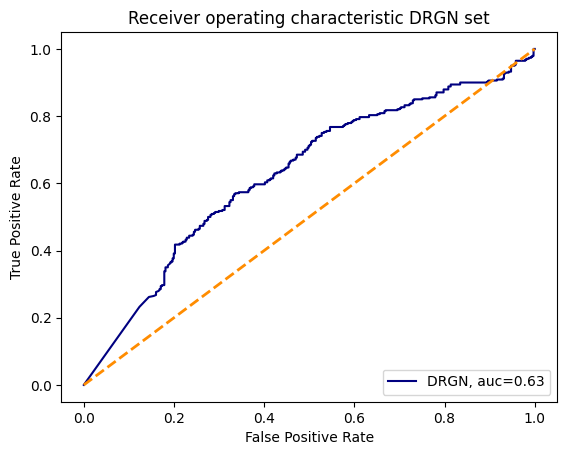

----------
Protein Q6N021 has 5 deleterious and 5 benign samples in training set of 3 Fold 
Protein Q6N021 has 0 deleterious and 4 benign samples in test set of 3 Fold 
Samples for Protein:  4
Precision: 0.75
Recall: 0.75
F-measure: 0.75
----------
Protein P40337 has 10 deleterious and 5 benign samples in training set of 3 Fold 
Protein P40337 has 3 deleterious and 18 benign samples in test set of 3 Fold 
Samples for Protein:  21
Precision: 0.5714285714285714
Recall: 0.5714285714285714
F-measure: 0.5714285714285714
----------
Protein Q99708 has 0 deleterious and 2 benign samples in training set of 3 Fold 
Protein Q99708 has 1 deleterious and 0 benign samples in test set of 3 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P42338 has 4 deleterious and 1 benign samples in training set of 3 Fold 
Protein P42338 has 1 deleterious and 1 benign samples in test set of 3 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
---------

<ipython-input-38-91901db5737a>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Groundtruth'] = y_drgn
<ipython-input-38-91901db5737a>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = predictions_drgn


Protein P54278 has 1 deleterious and 2 benign samples in test set of 3 Fold 
Samples for Protein:  3
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q14145 has 6 deleterious and 4 benign samples in training set of 3 Fold 
Protein Q14145 has 2 deleterious and 0 benign samples in test set of 3 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P49711 has 5 deleterious and 4 benign samples in training set of 3 Fold 
Protein P49711 has 1 deleterious and 0 benign samples in test set of 3 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P84022 has 11 deleterious and 8 benign samples in training set of 3 Fold 
Protein P84022 has 1 deleterious and 1 benign samples in test set of 3 Fold 
Samples for Protein:  2
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P52701 has 9 deleterious and 10 benign samples in training set of 3 Fold 
Protein P52701 has 1 deleterious and 5 benign samples in t

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.52      0.55       353
           1       0.59      0.67      0.62       366

    accuracy                           0.59       719
   macro avg       0.59      0.59      0.59       719
weighted avg       0.59      0.59      0.59       719

244 182 171 122
Sensitivity: 66.67
Specificity: 51.56
0.18442865715895101


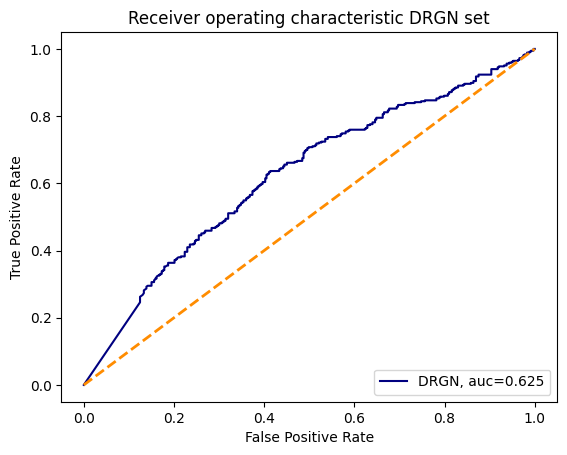

----------
Protein Q6N021 has 5 deleterious and 4 benign samples in training set of 4 Fold 
Protein Q6N021 has 0 deleterious and 3 benign samples in test set of 4 Fold 
Samples for Protein:  3
Precision: 0.3333333333333333
Recall: 0.3333333333333333
F-measure: 0.3333333333333333
----------
Protein Q99708 has 1 deleterious and 2 benign samples in training set of 4 Fold 
Protein Q99708 has 0 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P40337 has 8 deleterious and 7 benign samples in training set of 4 Fold 
Protein P40337 has 3 deleterious and 12 benign samples in test set of 4 Fold 
Samples for Protein:  15
Precision: 0.3333333333333333
Recall: 0.3333333333333333
F-measure: 0.3333333333333333
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 4 Fold 
Protein P42338 has 3 deleterious and 0 benign samples in test set of 4 Fold 
Samples for Protein:  3
Precision:

<ipython-input-38-91901db5737a>:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Groundtruth'] = y_drgn
<ipython-input-38-91901db5737a>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = predictions_drgn


Precision: 0.8
Recall: 0.8
F-measure: 0.8000000000000002
----------
Protein P49711 has 4 deleterious and 4 benign samples in training set of 4 Fold 
Protein P49711 has 2 deleterious and 0 benign samples in test set of 4 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q07812 has 0 deleterious and 1 benign samples in training set of 4 Fold 
Protein Q07812 has 1 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P84022 has 12 deleterious and 8 benign samples in training set of 4 Fold 
Protein P84022 has 1 deleterious and 0 benign samples in test set of 4 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P10721 has 15 deleterious and 13 benign samples in training set of 4 Fold 
Protein P10721 has 5 deleterious and 3 benign samples in test set of 4 Fold 
Samples for Protein:  8
Precision: 0.5
Recall: 0.5
F-measure: 0.5


In [ ]:
# Distribution of proteins in trianing / test se tof fold
# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs=200
lr = [3e-5]
#h = 1024
#h = 2048
h = 4096
#hidden2 =258
#hidden2=1024
hidden2=2048
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 5

accuracy, sensitivity, specificity, mcc, auc_dict = {}, {}, {}, {}, {}

for fold in range(n_folds):
  test = dif_mut_drgn_shuffled[fold*round(len(dif_mut_drgn_shuffled)/n_folds):(fold+1)*round(len(dif_mut_drgn_shuffled)/n_folds)]
  temp = test.mutation.str.split(pat='_',expand=True)[0]


  stacked_flat_drgn =[]
  for i, mut in test.iterrows():
    stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

  stacked_drgn = torch.stack(stacked_flat_drgn)
  print(stacked_drgn.shape)

  cond = dif_mut_shuffled['mutation'].isin(test['mutation'])
  training = dif_mut_shuffled.drop(dif_mut_shuffled[cond].index, inplace = False)

  #print('deleterious labels in Training for Fold ', fold, ': ', len(training[training['label']==1]))
  #print('benign labels in Training for Fold ', fold, ': ',  len(training[training['label']==0]))

  #print('deleterious labels in Test for Fold ', fold, ': ', len(test[test['label']==1]))
  #print('benign labels in Test for Fold ', fold, ': ',  len(test[test['label']==0]))
  #print('different genes in Fold ', fold, ': ',  len(temp.unique()))


  # exclude test mutations from training data
  stacked_flat =[]
  for i, mut in training.iterrows():
    stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

  stacked_gmm = torch.stack(stacked_flat)
  print(stacked_gmm.shape)

  training_temp = training.mutation.str.split(pat='_',expand=True)

  # how many proteins co exist in training set / test set
  prot_inters= intersection(training_temp[0].unique(), temp.unique())
  print('Proteins in common between training set / test set: ', len(prot_inters))#, ': ', prot_inters)
  '''
  # how many deleterious / benign per protein are in training versus test set
  for prot_int in prot_inters:
    training_df = training[training['mutation'].str.contains(prot_int)]
    del_training = len(training_df[training_df['label'] == 1])
    ben_training = len(training_df[training_df['label'] == 0])

    test_df =  test[test['mutation'].str.contains(prot_int)]
    del_test = len(test_df[test_df['label'] == 1])
    ben_test = len(test_df[test_df['label'] == 0])

    # creating the dataset
    data = {'Train del':del_training, 'Train ben':ben_training, 'Test del':del_test, 'Test ben':ben_test}
    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (5, 3))

    # creating the bar plot
    plt.bar(courses, values, color ='maroon',
            width = 0.4)

    plt.xlabel("")
    plt.ylabel("No. of samples")
    plt.title(prot_int)
    plt.xticks(rotation=45)
    plt.show()

  '''
  # seperate inputs and outputs
  X = stacked_gmm
  y = training['label']

  # Split, shuffle and stratify sequences, mutations, proteins and label
  X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, training_temp[1],  training_temp[0], test_size=0.0002, stratify=y, random_state=69)
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_test, y_test = np.array(X_test), np.array(y_test)

  del stacked_gmm, X
  gc.collect()

  train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
  val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

  #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))# Train
  #sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
  #sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

  train_loader = DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=2, drop_last=True)

  my_net = Classifier2L(h, hidden2, 0.3).to(device)
  #my_net = my_net = Classifier(h, 0.3).to(device)
  my_net.apply(init_weights)
  param_optimizer = list(my_net.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.02,
      },
  ]

  num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
  optimizer = torch.optim.AdamW(optimizer_parameters, lr=3e-5)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=1000, num_training_steps=num_train_steps
  )

  loss, acc = train_net_cross(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler )


  labels_drgn = test['label'].tolist()
  X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

  drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
  drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

  y_pred_list = []
  predictions_drgn= []
  my_net.eval()

  with torch.no_grad():
      for X_batch, _ in drgn_loader:
          X_batch = X_batch.to(device)
          y_test_pred = my_net(X_batch)
          #print(y_test_pred)
          predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
          #print(predictions_drgn)

  flat_list = []
  for sublist in predictions_drgn:
      for item in sublist:
          flat_list.append(item)

  predictions_drgn = [1 if i>=0.5 else 0 for i in flat_list]
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn))
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn).ravel()
  print(classification_report(y_drgn, predictions_drgn))
  print(tp, tn, fp, fn)
  TPR =tp / (tp + fn)
  print('Sensitivity: %.2f'  % (TPR*100))

  TNR = tn / (tn + fp)
  print('Specificity: %.2f'  % (TNR*100))
  print(matthews_corrcoef(y_drgn, predictions_drgn))

  lw = 2
  import matplotlib
  matplotlib.rc_file_defaults()
  fpr, tpr, _ = metrics.roc_curve(y_drgn[:len(predictions_drgn)],  flat_list)
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn)], flat_list)
  plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
  plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic DRGN set")
  plt.rcParams["figure.figsize"] = (10,10)
  plt.show()

  accuracy[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity[fold]=TPR*100
  specificity[fold]=TNR*100
  mcc[fold]= matthews_corrcoef(y_drgn, predictions_drgn)*100
  auc_dict[fold] =round(auc, 3)*100

  # find the accuracy per protein
  test['Groundtruth'] = y_drgn
  test['prediction'] = predictions_drgn

  training_df = pd.DataFrame(list(zip(prot_all_train.tolist(), y_train.tolist())),
               columns =['uniprot', 'label'])
  for prot_int in prot_inters:

    print('----------')

    df = training_df[training_df['uniprot']==prot_int]
    del_training = len(df[df['label'] == 1])
    ben_training = len(df[df['label'] == 0])
    print(f'Protein {prot_int} has {del_training} deleterious and {ben_training} benign samples in training set of {fold} Fold ')
    test_accu = test[test['mutation'].str.contains(prot_int)]
    del_test_accu = len(test_accu[test_accu['label'] == 1])
    ben_test_accu = len(test_accu[test_accu['label'] == 0])
    print(f'Protein {prot_int} has {del_test_accu} deleterious and {ben_test_accu} benign samples in test set of {fold} Fold ')

    print('Samples for Protein: ', len(test_accu))
    #print(classification_report(test_accu['Groundtruth'], test_accu['prediction']))
    precision, recall, fscore, support = precision_recall_fscore_support(test_accu['Groundtruth'], test_accu['prediction'], average='micro')#, pos_label=1)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-measure: {}'.format(fscore))

In [ ]:
ds=[accuracy,  sensitivity,  specificity,  mcc, auc_dict]
test = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

test['metric'] = ['accuracy']* len(accuracy) + ['sensitivity']* len(accuracy)+  ['specificity']* len(accuracy)+  ['mcc']* len(accuracy)+ ['AUC']* len(accuracy)
test['fold'] = fold_list
test['value'] = value_list

fig = px.violin(test, y="metric", x="value", color="metric", box=True, points="all", width=800, height=400, title="10 folds")
fig.show()

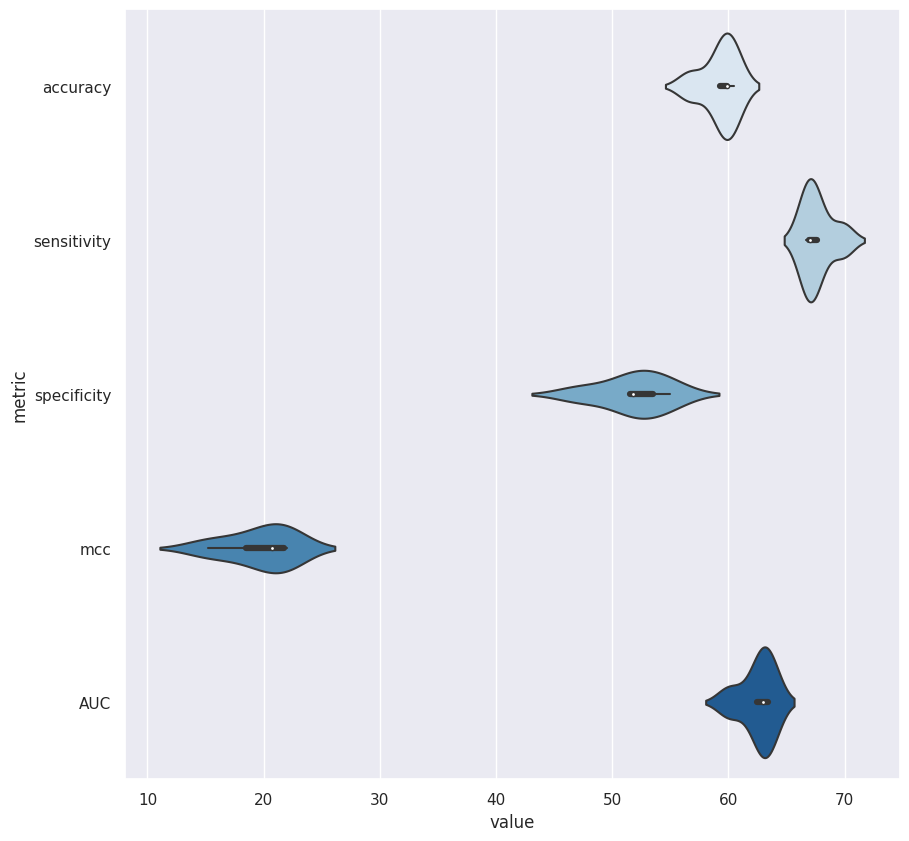

In [ ]:
sns.set(style="darkgrid")
sns.violinplot(data=test, x="value", y="metric", palette="Blues")
plt.show()

torch.Size([360, 2200])
torch.Size([6477, 2200])
Proteins in common between training set / test set:  94
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.68      0.49      0.57       204
           1       0.51      0.70      0.59       156

    accuracy                           0.58       360
   macro avg       0.60      0.59      0.58       360
weighted avg       0.61      0.58      0.58       360

109 100 104 47
Sensitivity: 69.87
Specificity: 49.02
0.19045532508299945


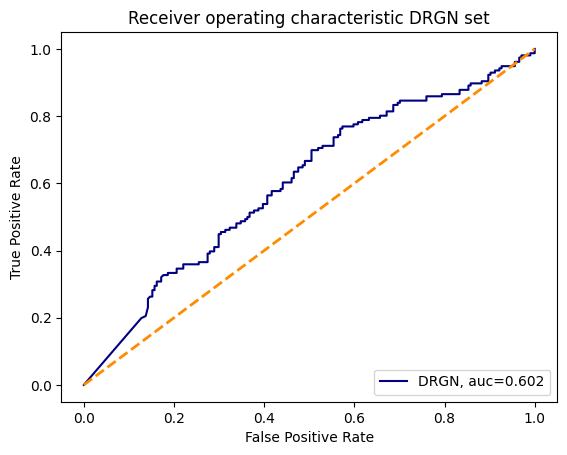

----------
Protein Q6N021 has 5 deleterious and 6 benign samples in training set of 0 Fold 
Protein Q6N021 has 0 deleterious and 2 benign samples in test set of 0 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P40337 has 10 deleterious and 7 benign samples in training set of 0 Fold 
Protein P40337 has 4 deleterious and 4 benign samples in test set of 0 Fold 
Samples for Protein:  8
Precision: 0.375
Recall: 0.375
F-measure: 0.375
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 0 Fold 
Protein P42338 has 1 deleterious and 0 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P54278 has 6 deleterious and 7 benign samples in training set of 0 Fold 
Protein P54278 has 1 deleterious and 1 benign samples in test set of 0 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q96SW2 has 0 deleterious and 2 ben

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q14145 has 5 deleterious and 4 benign samples in training set of 0 Fold 
Protein Q14145 has 2 deleterious and 0 benign samples in test set of 0 Fold 
Samples for Protein:  2
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P84022 has 11 deleterious and 8 benign samples in training set of 0 Fold 
Protein P84022 has 1 deleterious and 0 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P52701 has 9 deleterious and 9 benign samples in training set of 0 Fold 
Protein P52701 has 0 deleterious and 1 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P10721 has 15 deleterious and 13 benign samples in training set of 0 Fold 
Protein P10721 has 8 deleterious and 0 benign samples in test set of 0 Fold 
Samples for Protein:  8
Precision: 0.75
Recall: 0.75
F-measure: 0.75
----------
P

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.66      0.53      0.59       186
           1       0.59      0.71      0.64       174

    accuracy                           0.62       360
   macro avg       0.62      0.62      0.61       360
weighted avg       0.62      0.62      0.61       360

123 99 87 51
Sensitivity: 70.69
Specificity: 53.23
0.24241226393223447


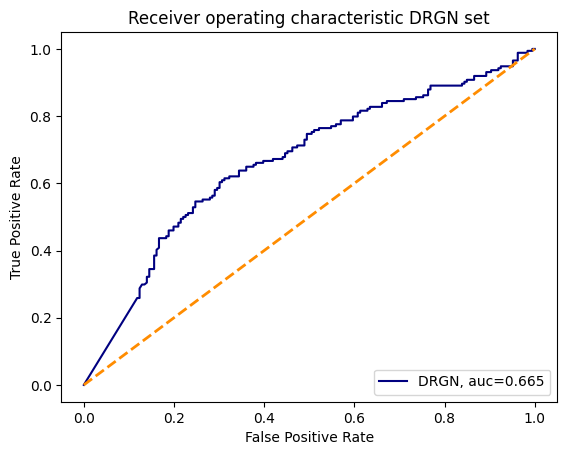

----------
Protein Q6N021 has 5 deleterious and 6 benign samples in training set of 1 Fold 
Protein Q6N021 has 0 deleterious and 1 benign samples in test set of 1 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P40337 has 10 deleterious and 7 benign samples in training set of 1 Fold 
Protein P40337 has 4 deleterious and 9 benign samples in test set of 1 Fold 
Samples for Protein:  13
Precision: 0.5384615384615384
Recall: 0.5384615384615384
F-measure: 0.5384615384615384
----------
Protein Q99708 has 1 deleterious and 1 benign samples in training set of 1 Fold 
Protein Q99708 has 0 deleterious and 1 benign samples in test set of 1 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P54278 has 7 deleterious and 5 benign samples in training set of 1 Fold 
Protein P54278 has 0 deleterious and 5 benign samples in test set of 1 Fold 
Samples for Protein:  5
Precision: 0.6
Recall: 0.6
F-measure: 0.6
----------
Pr

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P52701 has 9 deleterious and 10 benign samples in training set of 1 Fold 
Protein P52701 has 2 deleterious and 1 benign samples in test set of 1 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P43246 has 14 deleterious and 13 benign samples in training set of 1 Fold 
Protein P43246 has 1 deleterious and 2 benign samples in test set of 1 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein O14746 has 8 deleterious and 9 benign samples in training set of 1 Fold 
Protein O14746 has 0 deleterious and 3 benign samples in test set of 1 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein Q05209 has 1 deleterious and 2 benign samples in training set of 1 Fold 
Protein Q05209 has 0 de

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.49      0.54       196
           1       0.50      0.61      0.55       164

    accuracy                           0.55       360
   macro avg       0.55      0.55      0.55       360
weighted avg       0.56      0.55      0.55       360

100 97 99 64
Sensitivity: 60.98
Specificity: 49.49
0.10482540553058603


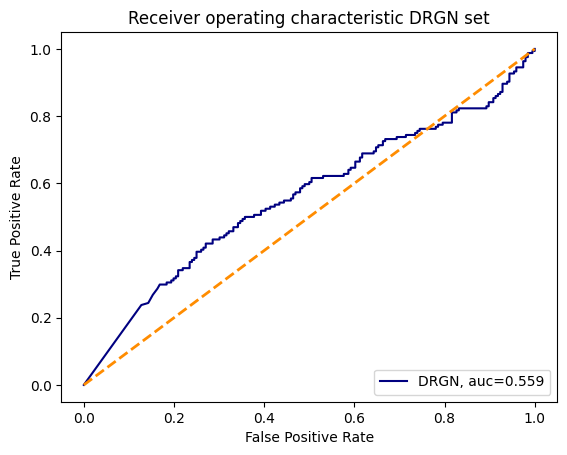

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



----------
Protein Q6N021 has 5 deleterious and 6 benign samples in training set of 2 Fold 
Protein Q6N021 has 0 deleterious and 1 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P40337 has 10 deleterious and 7 benign samples in training set of 2 Fold 
Protein P40337 has 0 deleterious and 12 benign samples in test set of 2 Fold 
Samples for Protein:  12
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P54278 has 7 deleterious and 8 benign samples in training set of 2 Fold 
Protein P54278 has 1 deleterious and 3 benign samples in test set of 2 Fold 
Samples for Protein:  4
Precision: 0.25
Recall: 0.25
F-measure: 0.25
----------
Protein P49711 has 5 deleterious and 4 benign samples in training set of 2 Fold 
Protein P49711 has 1 deleterious and 0 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q07812 has 1 deleterious and 1 beni

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.72      0.50      0.59       191
           1       0.58      0.78      0.66       169

    accuracy                           0.63       360
   macro avg       0.65      0.64      0.63       360
weighted avg       0.65      0.63      0.62       360

132 95 96 37
Sensitivity: 78.11
Specificity: 49.74
0.2883690446961912


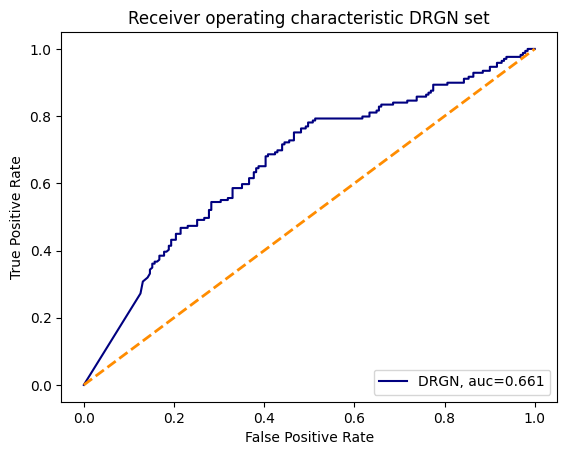

----------
Protein P40337 has 9 deleterious and 6 benign samples in training set of 3 Fold 
Protein P40337 has 0 deleterious and 6 benign samples in test set of 3 Fold 
Samples for Protein:  6
Precision: 0.3333333333333333
Recall: 0.3333333333333333
F-measure: 0.3333333333333333
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 3 Fold 
Protein P42338 has 2 deleterious and 0 benign samples in test set of 3 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P54278 has 7 deleterious and 7 benign samples in training set of 3 Fold 
Protein P54278 has 0 deleterious and 3 benign samples in test set of 3 Fold 
Samples for Protein:  3
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q96SW2 has 1 deleterious and 2 benign samples in training set of 3 Fold 
Protein Q96SW2 has 0 deleterious and 1 benign samples in test set of 3 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Prot

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Samples for Protein:  6
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P21802-20 has 0 deleterious and 2 benign samples in training set of 3 Fold 
Protein P21802-20 has 0 deleterious and 1 benign samples in test set of 3 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P43246 has 13 deleterious and 15 benign samples in training set of 3 Fold 
Protein P43246 has 3 deleterious and 2 benign samples in test set of 3 Fold 
Samples for Protein:  5
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein O14746 has 8 deleterious and 9 benign samples in training set of 3 Fold 
Protein O14746 has 0 deleterious and 2 benign samples in test set of 3 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q05209 has 0 deleterious and 2 benign samples in training set of 3 Fold 
Protein Q05209 has 1 deleterious and 0 benign samples in test set of 3 Fold 
Samples

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       198
           1       0.57      0.71      0.63       162

    accuracy                           0.63       360
   macro avg       0.64      0.64      0.63       360
weighted avg       0.64      0.63      0.63       360

115 111 87 47
Sensitivity: 70.99
Specificity: 56.06
0.27115974244926083


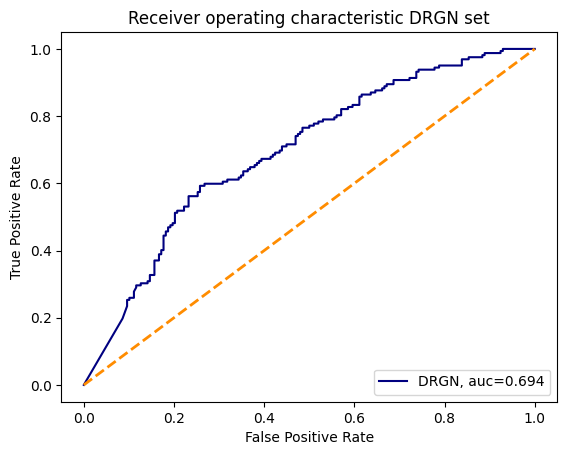

----------
Protein Q6N021 has 5 deleterious and 6 benign samples in training set of 4 Fold 
Protein Q6N021 has 0 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P40337 has 9 deleterious and 7 benign samples in training set of 4 Fold 
Protein P40337 has 1 deleterious and 9 benign samples in test set of 4 Fold 
Samples for Protein:  10
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 4 Fold 
Protein P42338 has 1 deleterious and 0 benign samples in test set of 4 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P54278 has 4 deleterious and 8 benign samples in training set of 4 Fold 
Protein P54278 has 3 deleterious and 0 benign samples in test set of 4 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Pro

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P43246 has 14 deleterious and 11 benign samples in training set of 4 Fold 
Protein P43246 has 3 deleterious and 4 benign samples in test set of 4 Fold 
Samples for Protein:  7
Precision: 0.7142857142857143
Recall: 0.7142857142857143
F-measure: 0.7142857142857143
----------
Protein O14746 has 6 deleterious and 6 benign samples in training set of 4 Fold 
Protein O14746 has 1 deleterious and 8 benign samples in test set of 4 Fold 
Samples for Protein:  9
Precision: 0.7777777777777778
Recall: 0.7777777777777778
F-measure: 0.7777777777777778
----------
Protein Q05209 has 1 deleterious and 1 benign samples in training set of 4 Fold 
Protein Q05209 has 0 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q9BX63 has 4 deleterious and 4 benign samples in training set of 4 Fold 
Protein Q9BX63 has 0 deleterious and 3 benign samples in test set of 

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.62      0.47      0.54       199
           1       0.50      0.64      0.56       161

    accuracy                           0.55       360
   macro avg       0.56      0.56      0.55       360
weighted avg       0.56      0.55      0.55       360

103 94 105 58
Sensitivity: 63.98
Specificity: 47.24
0.11286086910829378


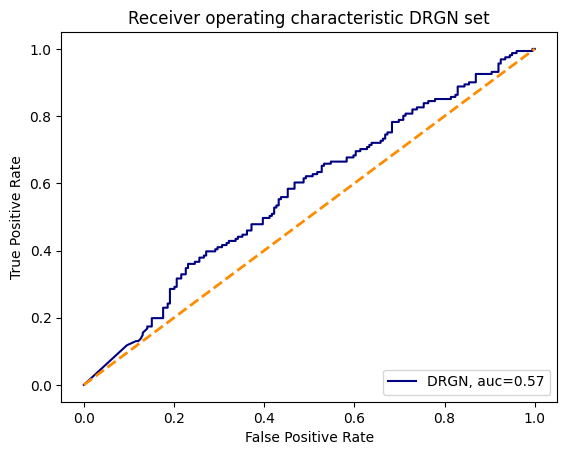

----------
Protein Q6N021 has 5 deleterious and 3 benign samples in training set of 5 Fold 
Protein Q6N021 has 0 deleterious and 4 benign samples in test set of 5 Fold 
Samples for Protein:  4
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P40337 has 10 deleterious and 7 benign samples in training set of 5 Fold 


<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Protein P40337 has 1 deleterious and 5 benign samples in test set of 5 Fold 
Samples for Protein:  6
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q99708 has 1 deleterious and 1 benign samples in training set of 5 Fold 
Protein Q99708 has 0 deleterious and 1 benign samples in test set of 5 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P54278 has 7 deleterious and 7 benign samples in training set of 5 Fold 
Protein P54278 has 0 deleterious and 3 benign samples in test set of 5 Fold 
Samples for Protein:  3
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q14145 has 5 deleterious and 4 benign samples in training set of 5 Fold 
Protein Q14145 has 2 deleterious and 0 benign samples in test set of 5 Fold 
Samples for Protein:  2
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P84022 has 11 deleterious and 8 benign samples in training set of 5 Fold 
Protein P84022 has 1 deleterious and 1 benign samples in te

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.64      0.48      0.55       189
           1       0.55      0.71      0.62       171

    accuracy                           0.59       360
   macro avg       0.60      0.59      0.58       360
weighted avg       0.60      0.59      0.58       360

121 90 99 50
Sensitivity: 70.76
Specificity: 47.62
0.18827043647441977


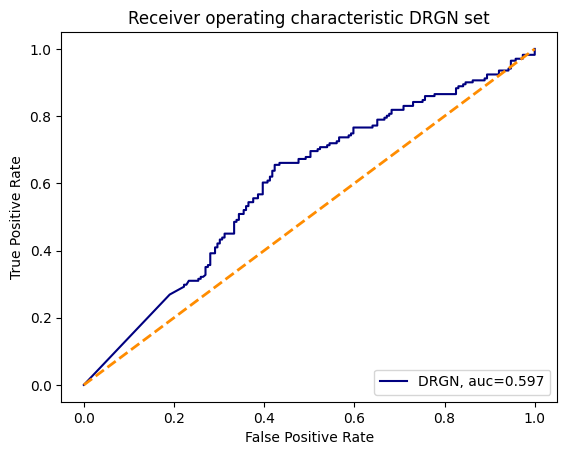

----------
Protein P40337 has 10 deleterious and 7 benign samples in training set of 6 Fold 
Protein P40337 has 1 deleterious and 5 benign samples in test set of 6 Fold 
Samples for Protein:  6
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P42338 has 4 deleterious and 1 benign samples in training set of 6 Fold 
Protein P42338 has 0 deleterious and 1 benign samples in test set of 6 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P54278 has 7 deleterious and 8 benign samples in training set of 6 Fold 
Protein P54278 has 2 deleterious and 0 benign samples in test set of 6 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q14145 has 6 deleterious and 4 benign samples in training set of 6 Fold 
Protein Q14145 has 1 deleterious and 0 benign samples in test set of 6 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P49711 has 5 deleterious and 4 benign sa

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Samples for Protein:  4
Precision: 0.75
Recall: 0.75
F-measure: 0.75
----------
Protein O14746 has 7 deleterious and 8 benign samples in training set of 6 Fold 
Protein O14746 has 0 deleterious and 3 benign samples in test set of 6 Fold 
Samples for Protein:  3
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q9BX63 has 4 deleterious and 3 benign samples in training set of 6 Fold 
Protein Q9BX63 has 0 deleterious and 4 benign samples in test set of 6 Fold 
Samples for Protein:  4
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q92560 has 6 deleterious and 9 benign samples in training set of 6 Fold 
Protein Q92560 has 2 deleterious and 0 benign samples in test set of 6 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 6 Fold 
Protein P35222 has 6 deleterious and 0 benign samples in test set of 6 Fold 
Samples for Protein:  6
Precision: 0.16666666666666666


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.63      0.51      0.56       189
           1       0.55      0.67      0.60       171

    accuracy                           0.58       360
   macro avg       0.59      0.59      0.58       360
weighted avg       0.59      0.58      0.58       360

114 96 93 57
Sensitivity: 66.67
Specificity: 50.79
0.17638035194568524


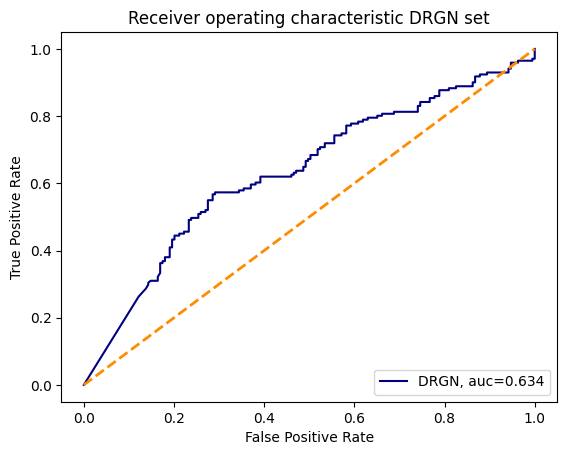

----------
Protein Q6N021 has 5 deleterious and 5 benign samples in training set of 7 Fold 
Protein Q6N021 has 0 deleterious and 4 benign samples in test set of 7 Fold 
Samples for Protein:  4
Precision: 0.75
Recall: 0.75
F-measure: 0.75
----------
Protein P40337 has 10 deleterious and 5 benign samples in training set of 7 Fold 
Protein P40337 has 2 deleterious and 13 benign samples in test set of 7 Fold 
Samples for Protein:  15
Precision: 0.4666666666666667
Recall: 0.4666666666666667
F-measure: 0.4666666666666667
----------
Protein Q99708 has 0 deleterious and 2 benign samples in training set of 7 Fold 
Protein Q99708 has 1 deleterious and 0 benign samples in test set of 7 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 7 Fold 
Protein P42338 has 1 deleterious and 0 benign samples in test set of 7 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
---------

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




F-measure: 0.5
----------
Protein Q14145 has 6 deleterious and 4 benign samples in training set of 7 Fold 
Protein Q14145 has 1 deleterious and 0 benign samples in test set of 7 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P52701 has 9 deleterious and 10 benign samples in training set of 7 Fold 
Protein P52701 has 1 deleterious and 2 benign samples in test set of 7 Fold 
Samples for Protein:  3
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P10721 has 15 deleterious and 13 benign samples in training set of 7 Fold 
Protein P10721 has 5 deleterious and 0 benign samples in test set of 7 Fold 
Samples for Protein:  5
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P43246 has 13 deleterious and 14 benign samples in training set of 7 Fold 
Protein P43246 has 2 deleterious and 2 benign samples in test set of 7 Fold 
Samples for Protein:  4
Precision: 0.75
Recall: 0.75
F-measure: 0.75
----------
Protein O14746 has 8 dele

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.59      0.46      0.51       178
           1       0.57      0.69      0.62       182

    accuracy                           0.57       360
   macro avg       0.58      0.57      0.57       360
weighted avg       0.58      0.57      0.57       360

126 81 97 56
Sensitivity: 69.23
Specificity: 45.51
0.1517483593808524


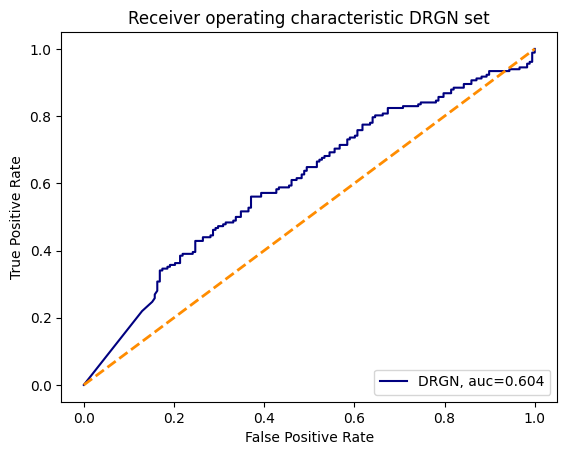

----------
Protein Q99708 has 1 deleterious and 2 benign samples in training set of 8 Fold 
Protein Q99708 has 0 deleterious and 1 benign samples in test set of 8 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P40337 has 10 deleterious and 7 benign samples in training set of 8 Fold 
Protein P40337 has 0 deleterious and 8 benign samples in test set of 8 Fold 
Samples for Protein:  8
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 8 Fold 
Protein P42338 has 1 deleterious and 0 benign samples in test set of 8 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P54278 has 6 deleterious and 8 benign samples in training set of 8 Fold 
Protein P54278 has 1 deleterious and 2 benign samples in test set of 8 Fold 
Samples for Protein:  3
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q14145 has 6 deleterious and 3 benign sa

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Protein P52701 has 1 deleterious and 3 benign samples in test set of 8 Fold 
Samples for Protein:  4
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P43246 has 14 deleterious and 13 benign samples in training set of 8 Fold 
Protein P43246 has 3 deleterious and 2 benign samples in test set of 8 Fold 
Samples for Protein:  5
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein O14746 has 7 deleterious and 8 benign samples in training set of 8 Fold 
Protein O14746 has 0 deleterious and 2 benign samples in test set of 8 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q05209 has 1 deleterious and 1 benign samples in training set of 8 Fold 
Protein Q05209 has 0 deleterious and 1 benign samples in test set of 8 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q92560 has 7 deleterious and 9 benign samples in training set of 8 Fold 
Protein Q92560 has 1 deleterious and 0 benign samples in t

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.62      0.49      0.54       177
           1       0.59      0.71      0.64       183

    accuracy                           0.60       360
   macro avg       0.60      0.60      0.59       360
weighted avg       0.60      0.60      0.59       360

130 86 91 53
Sensitivity: 71.04
Specificity: 48.59
0.20152851114363698


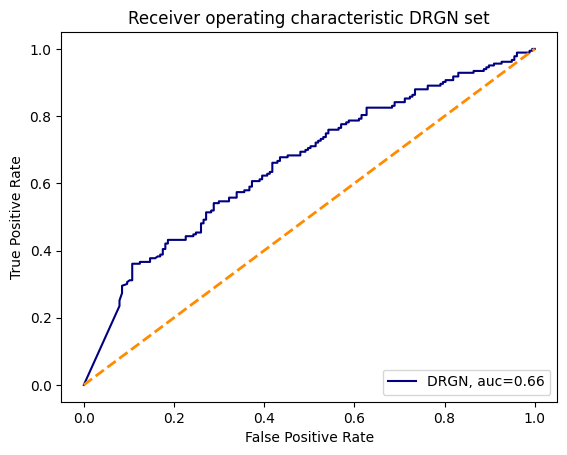

----------
Protein Q6N021 has 5 deleterious and 4 benign samples in training set of 9 Fold 
Protein Q6N021 has 0 deleterious and 3 benign samples in test set of 9 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P40337 has 8 deleterious and 7 benign samples in training set of 9 Fold 
Protein P40337 has 3 deleterious and 4 benign samples in test set of 9 Fold 
Samples for Protein:  7
Precision: 0.14285714285714285
Recall: 0.14285714285714285
F-measure: 0.14285714285714285
----------
Protein P42338 has 4 deleterious and 2 benign samples in training set of 9 Fold 
Protein P42338 has 2 deleterious and 0 benign samples in test set of 9 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P54278 has 6 deleterious and 8 benign samples in training set of 9 Fold 
Protein P54278 has 1 deleterious and 1 benign samples in test set of 9 Fold 
Samples for Protein:  2
Precision

<ipython-input-41-32752c7a31f6>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-32752c7a31f6>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q06187-2 has 0 deleterious and 2 benign samples in training set of 9 Fold 
Protein Q06187-2 has 0 deleterious and 1 benign samples in test set of 9 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q9BX63 has 4 deleterious and 5 benign samples in training set of 9 Fold 
Protein Q9BX63 has 0 deleterious and 1 benign samples in test set of 9 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q92560 has 7 deleterious and 9 benign samples in training set of 9 Fold 
Protein Q92560 has 1 deleterious and 0 benign samples in test set of 9 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P35222 has 11 deleterious and 10 benign samples in training set of 9 Fold 
Protein P35222 has 2 deleterious and 1 benign samples in test set of 9 Fold 
Samples for Protein:  3
Precision: 0.3333333333333333
Recall: 0.33333333333333

In [ ]:
# Distribution of proteins in trianing / test se tof fold
# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs=200
lr = [3e-5]
#h = 1024
#h = 2048
h = 4096
#hidden2 =258
#hidden2=1024
hidden2=2048
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 10

accuracy, sensitivity, specificity, mcc, auc_dict = {}, {}, {}, {}, {}

for fold in range(n_folds):
  test = dif_mut_drgn_shuffled[fold*round(len(dif_mut_drgn_shuffled)/n_folds):(fold+1)*round(len(dif_mut_drgn_shuffled)/n_folds)]
  temp = test.mutation.str.split(pat='_',expand=True)[0]


  stacked_flat_drgn =[]
  for i, mut in test.iterrows():
    stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

  stacked_drgn = torch.stack(stacked_flat_drgn)
  print(stacked_drgn.shape)

  cond = dif_mut_shuffled['mutation'].isin(test['mutation'])
  training = dif_mut_shuffled.drop(dif_mut_shuffled[cond].index, inplace = False)

  #print('deleterious labels in Training for Fold ', fold, ': ', len(training[training['label']==1]))
  #print('benign labels in Training for Fold ', fold, ': ',  len(training[training['label']==0]))

  #print('deleterious labels in Test for Fold ', fold, ': ', len(test[test['label']==1]))
  #print('benign labels in Test for Fold ', fold, ': ',  len(test[test['label']==0]))
  #print('different genes in Fold ', fold, ': ',  len(temp.unique()))


  # exclude test mutations from training data
  stacked_flat =[]
  for i, mut in training.iterrows():
    stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

  stacked_gmm = torch.stack(stacked_flat)
  print(stacked_gmm.shape)

  training_temp = training.mutation.str.split(pat='_',expand=True)

  # how many proteins co exist in training set / test set
  prot_inters= intersection(training_temp[0].unique(), temp.unique())
  print('Proteins in common between training set / test set: ', len(prot_inters))#, ': ', prot_inters)
  '''
  # how many deleterious / benign per protein are in training versus test set
  for prot_int in prot_inters:
    training_df = training[training['mutation'].str.contains(prot_int)]
    del_training = len(training_df[training_df['label'] == 1])
    ben_training = len(training_df[training_df['label'] == 0])

    test_df =  test[test['mutation'].str.contains(prot_int)]
    del_test = len(test_df[test_df['label'] == 1])
    ben_test = len(test_df[test_df['label'] == 0])

    # creating the dataset
    data = {'Train del':del_training, 'Train ben':ben_training, 'Test del':del_test, 'Test ben':ben_test}
    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (5, 3))

    # creating the bar plot
    plt.bar(courses, values, color ='maroon',
            width = 0.4)

    plt.xlabel("")
    plt.ylabel("No. of samples")
    plt.title(prot_int)
    plt.xticks(rotation=45)
    plt.show()

  '''
  # seperate inputs and outputs
  X = stacked_gmm
  y = training['label']

  # Split, shuffle and stratify sequences, mutations, proteins and label
  X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, training_temp[1],  training_temp[0], test_size=0.0002, stratify=y, random_state=69)
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_test, y_test = np.array(X_test), np.array(y_test)

  del stacked_gmm, X
  gc.collect()

  train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
  val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

  #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))# Train
  #sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
  #sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

  train_loader = DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=2, drop_last=True)

  my_net = Classifier2L(h, hidden2, 0.3).to(device)
  #my_net = my_net = Classifier(h, 0.3).to(device)
  my_net.apply(init_weights)
  param_optimizer = list(my_net.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.02,
      },
  ]

  num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
  optimizer = torch.optim.AdamW(optimizer_parameters, lr=3e-5)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=1000, num_training_steps=num_train_steps
  )

  loss, acc = train_net_cross(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler )


  labels_drgn = test['label'].tolist()
  X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

  drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
  drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)


  y_pred_list = []
  predictions_drgn= []
  my_net.eval()

  with torch.no_grad():
      for X_batch, _ in drgn_loader:
          X_batch = X_batch.to(device)
          y_test_pred = my_net(X_batch)
          #print(y_test_pred)
          predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
          #print(predictions_drgn)

  flat_list = []
  for sublist in predictions_drgn:
      for item in sublist:
          flat_list.append(item)

  predictions_drgn = [1 if i>=0.5 else 0 for i in flat_list]
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn))
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn).ravel()
  print(classification_report(y_drgn, predictions_drgn))
  print(tp, tn, fp, fn)
  TPR =tp / (tp + fn)
  print('Sensitivity: %.2f'  % (TPR*100))

  TNR = tn / (tn + fp)
  print('Specificity: %.2f'  % (TNR*100))
  print(matthews_corrcoef(y_drgn, predictions_drgn))

  lw = 2
  import matplotlib
  matplotlib.rc_file_defaults()
  fpr, tpr, _ = metrics.roc_curve(y_drgn[:len(predictions_drgn)],  flat_list)
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn)], flat_list)
  plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
  plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic DRGN set")
  plt.rcParams["figure.figsize"] = (10,10)
  plt.show()

  accuracy[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity[fold]=TPR*100
  specificity[fold]=TNR*100
  mcc[fold]= matthews_corrcoef(y_drgn, predictions_drgn)*100
  auc_dict[fold] =round(auc, 3)*100

  # find the accuracy per protein
  test['Groundtruth'] = y_drgn
  test['prediction'] = predictions_drgn

  training_df = pd.DataFrame(list(zip(prot_all_train.tolist(), y_train.tolist())),
               columns =['uniprot', 'label'])
  for prot_int in prot_inters:

    print('----------')

    df = training_df[training_df['uniprot']==prot_int]
    del_training = len(df[df['label'] == 1])
    ben_training = len(df[df['label'] == 0])
    print(f'Protein {prot_int} has {del_training} deleterious and {ben_training} benign samples in training set of {fold} Fold ')
    test_accu = test[test['mutation'].str.contains(prot_int)]
    del_test_accu = len(test_accu[test_accu['label'] == 1])
    ben_test_accu = len(test_accu[test_accu['label'] == 0])
    print(f'Protein {prot_int} has {del_test_accu} deleterious and {ben_test_accu} benign samples in test set of {fold} Fold ')

    print('Samples for Protein: ', len(test_accu))
    #print(classification_report(test_accu['Groundtruth'], test_accu['prediction']))
    precision, recall, fscore, support = precision_recall_fscore_support(test_accu['Groundtruth'], test_accu['prediction'], average='micro')#, pos_label=1)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-measure: {}'.format(fscore))

In [ ]:
ds=[accuracy,  sensitivity,  specificity,  mcc, auc_dict]
test = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

test['metric'] = ['accuracy']* len(accuracy) + ['sensitivity']* len(accuracy)+  ['specificity']* len(accuracy)+  ['mcc']* len(accuracy)+ ['AUC']* len(accuracy)
test['fold'] = fold_list
test['value'] = value_list

fig = px.violin(test, y="metric", x="value", color="metric", box=True, points="all", width=800, height=400, title="10 folds")
fig.show()

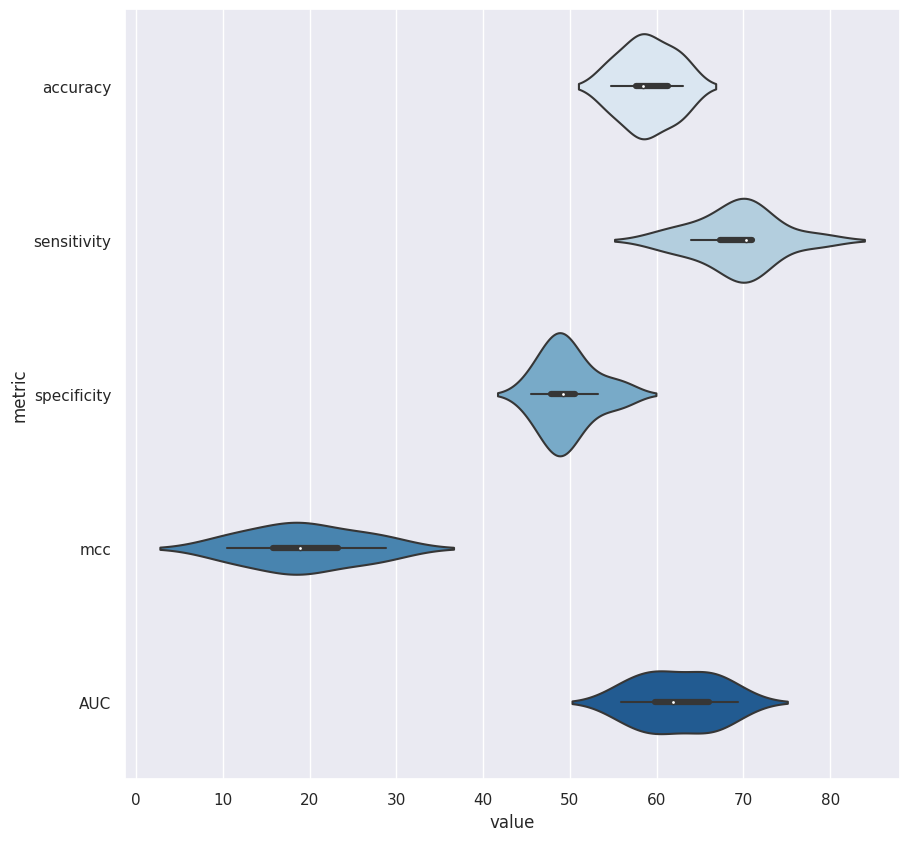

In [ ]:
sns.set(style="darkgrid")
sns.violinplot(data=test, x="value", y="metric", palette="Blues")
plt.show()

torch.Size([180, 2200])
torch.Size([6548, 2200])
Proteins in common between training set / test set:  70
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.68      0.53      0.60        88
           1       0.63      0.76      0.69        92

    accuracy                           0.65       180
   macro avg       0.66      0.65      0.64       180
weighted avg       0.66      0.65      0.65       180

70 47 41 22
Sensitivity: 76.09
Specificity: 53.41
0.30325853871592073


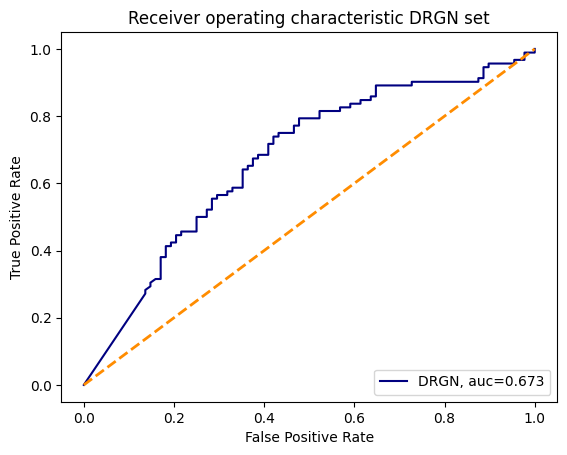

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 0 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 0 Fold 
Protein Q15831 has 2 deleterious and 0 benign samples in test set of 0 Fold 


<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P07333 has 10 deleterious and 11 benign samples in training set of 0 Fold 
Protein P07333 has 0 deleterious and 1 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P06400 has 13 deleterious and 12 benign samples in training set of 0 Fold 
Protein P06400 has 0 deleterious and 1 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P31751 has 6 deleterious and 3 benign samples in training set of 0 Fold 
Protein P31751 has 0 deleterious and 1 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P40238 has 9 deleterious and 10 benign samples in training set of 0 Fold 
Protein P40238 has 0 deleterious and 1 benign samples in test set of 0 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-me

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.70      0.58      0.64        98
           1       0.59      0.71      0.64        82

    accuracy                           0.64       180
   macro avg       0.64      0.64      0.64       180
weighted avg       0.65      0.64      0.64       180

58 57 41 24
Sensitivity: 70.73
Specificity: 58.16
0.2892558457423497


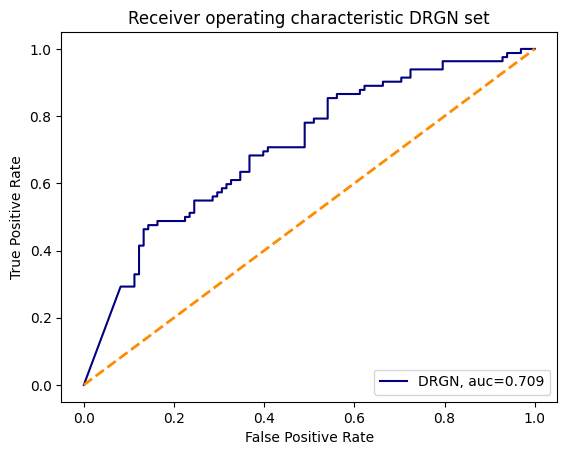

----------
Protein P52701 has 8 deleterious and 8 benign samples in training set of 1 Fold 
Protein P52701 has 0 deleterious and 3 benign samples in test set of 1 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 1 Fold 
Protein Q13485 has 2 deleterious and 0 benign samples in test set of 1 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q86YC2 has 5 deleterious and 6 benign samples in training set of 1 Fold 
Protein Q86YC2 has 0 deleterious and 1 benign samples in test set of 1 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 1 Fold 
Protein P01112 has 1 deleterious and 0 benign samples in test set of 1 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Prot

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P00519 has 12 deleterious and 27 benign samples in training set of 1 Fold 
Protein P00519 has 5 deleterious and 0 benign samples in test set of 1 Fold 
Samples for Protein:  5
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P40238 has 9 deleterious and 9 benign samples in training set of 1 Fold 
Protein P40238 has 0 deleterious and 1 benign samples in test set of 1 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P36888 has 26 deleterious and 24 benign samples in training set of 1 Fold 
Protein P36888 has 2 deleterious and 0 benign samples in test set of 1 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P11362-4 has 1 deleterious and 0 benign samples in training set of 1 Fold 
Protein P11362-4 has 0 deleterious and 1 benign samples in test set of 1 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.57      0.58        86
           1       0.62      0.65      0.64        94

    accuracy                           0.61       180
   macro avg       0.61      0.61      0.61       180
weighted avg       0.61      0.61      0.61       180

61 49 37 33
Sensitivity: 64.89
Specificity: 56.98
0.2193558111713891


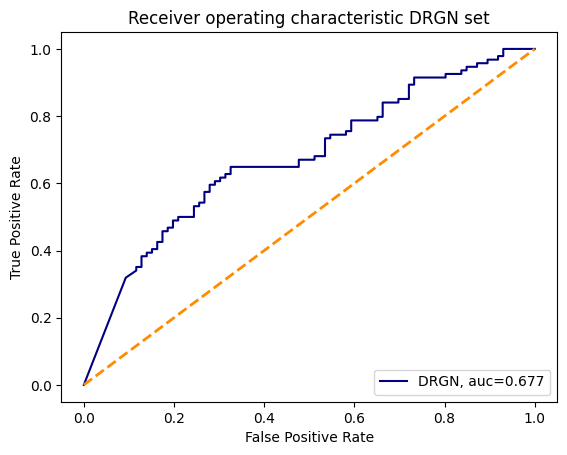

----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 2 Fold 
Protein Q15831 has 3 deleterious and 0 benign samples in test set of 2 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 2 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 10 deleterious and 10 benign samples in training set of 2 Fold 
Protein P07333 has 0 deleterious and 1 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q96BI1 has 1 deleterious and 2 benign samples in training set of 2 Fold 
Protein Q96BI1 has 0 deleterious and 1 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Pr

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Protein Q15910-4 has 0 deleterious and 1 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q07812 has 0 deleterious and 2 benign samples in training set of 2 Fold 
Protein Q07812 has 1 deleterious and 0 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q06124 has 8 deleterious and 7 benign samples in training set of 2 Fold 
Protein Q06124 has 1 deleterious and 3 benign samples in test set of 2 Fold 
Samples for Protein:  4
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q99062 has 2 deleterious and 2 benign samples in training set of 2 Fold 
Protein Q99062 has 0 deleterious and 1 benign samples in test set of 2 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 2 Fold 
Protein P35222 has 3 deleterious and 0 benign samples in

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.66      0.54      0.60        92
           1       0.60      0.70      0.65        88

    accuracy                           0.62       180
   macro avg       0.63      0.62      0.62       180
weighted avg       0.63      0.62      0.62       180

62 50 42 26
Sensitivity: 70.45
Specificity: 54.35
0.25101807395201026


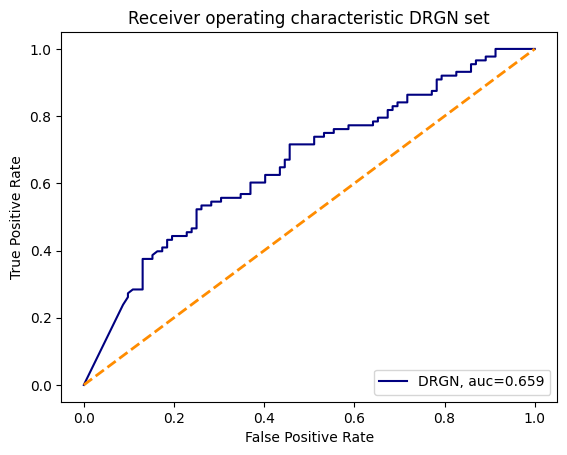

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 3 Fold 
Protein Q13485 has 4 deleterious and 0 benign samples in test set of 3 Fold 
Samples for Protein:  4
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 3 Fold 
Protein Q15831 has 2 deleterious and 0 benign samples in test set of 3 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P06400 has 13 deleterious and 13 benign samples in training set of 3 Fold 
Protein P06400 has 0 deleterious and 1 benign samples in test set of 3 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P36888 has 26 deleterious and 24 benign samples in training set of 3 Fold 
Protein P36888 has 3 deleterious and 0 benign samples in test set of 3 Fold 
Samples for Protein:  3
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P11362-4 has 1 deleterious and 0 beni

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P18074 has 16 deleterious and 14 benign samples in training set of 3 Fold 
Protein P18074 has 2 deleterious and 1 benign samples in test set of 3 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P04637 has 93 deleterious and 91 benign samples in training set of 3 Fold 
Protein P04637 has 10 deleterious and 1 benign samples in test set of 3 Fold 
Samples for Protein:  11
Precision: 0.6363636363636364
Recall: 0.6363636363636364
F-measure: 0.6363636363636364
----------
Protein P29992 has 4 deleterious and 2 benign samples in training set of 3 Fold 
Protein P29992 has 0 deleterious and 1 benign samples in test set of 3 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P38398 has 113 deleterious and 115 benign samples in training set of 3 Fold 
Protein P38398 has 2 deleterious and 2 benign samples in test

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.58      0.43      0.50        90
           1       0.55      0.69      0.61        90

    accuracy                           0.56       180
   macro avg       0.57      0.56      0.55       180
weighted avg       0.57      0.56      0.55       180

62 39 51 28
Sensitivity: 68.89
Specificity: 43.33
0.12642008036328553


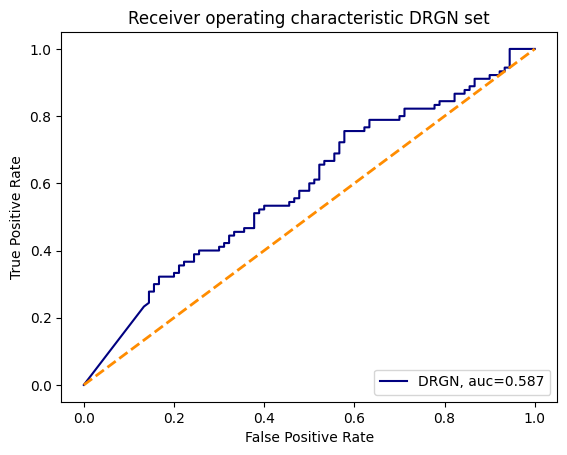

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 4 Fold 
Protein Q13485 has 2 deleterious and 0 benign samples in test set of 4 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 4 Fold 
Protein Q15831 has 2 deleterious and 0 benign samples in test set of 4 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 4 Fold 
Protein P01112 has 0 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P07333 has 8 deleterious and 10 benign samples in training set of 4 Fold 
Protein P07333 has 1 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P06400 has 11 deleterious and 14 benign 

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein O14746 has 8 deleterious and 9 benign samples in training set of 4 Fold 
Protein O14746 has 0 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q06124 has 9 deleterious and 7 benign samples in training set of 4 Fold 
Protein Q06124 has 1 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 4 Fold 
Protein P35222 has 4 deleterious and 0 benign samples in test set of 4 Fold 
Samples for Protein:  4
Precision: 0.25
Recall: 0.25
F-measure: 0.25
----------
Protein P18074 has 18 deleterious and 14 benign samples in training set of 4 Fold 
Protein P18074 has 0 deleterious and 1 benign samples in test set of 4 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------


  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.65      0.55      0.60       101
           1       0.52      0.62      0.57        79

    accuracy                           0.58       180
   macro avg       0.59      0.59      0.58       180
weighted avg       0.59      0.58      0.58       180

49 56 45 30
Sensitivity: 62.03
Specificity: 55.45
0.17357028988885792


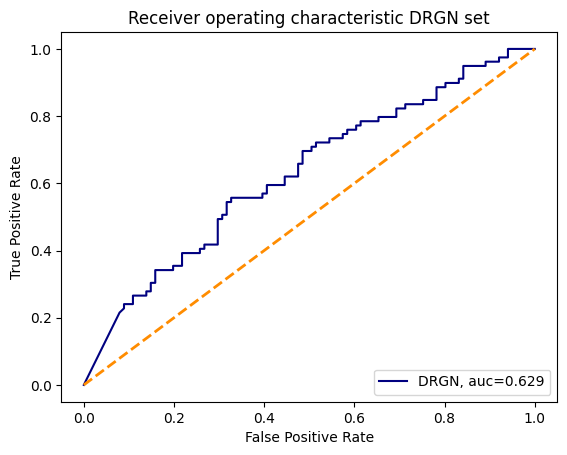

----------
Protein P52701 has 9 deleterious and 10 benign samples in training set of 5 Fold 
Protein P52701 has 1 deleterious and 4 benign samples in test set of 5 Fold 
Samples for Protein:  5
Precision: 0.8
Recall: 0.8
F-measure: 0.8000000000000002
----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 5 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 5 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 5 Fold 
Protein Q15831 has 0 deleterious and 1 benign samples in test set of 5 Fold 
Samples for Protein:  1


<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 5 Fold 
Protein P01112 has 2 deleterious and 0 benign samples in test set of 5 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P01106 has 2 deleterious and 3 benign samples in training set of 5 Fold 
Protein P01106 has 1 deleterious and 1 benign samples in test set of 5 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P31751 has 6 deleterious and 4 benign samples in training set of 5 Fold 
Protein P31751 has 0 deleterious and 1 benign samples in test set of 5 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P21802-20 has 0 deleterious and 2 benign samples in training set of 5 Fold 
Protein P21802-20 has 0 deleterious and 1 benign samples in test set of 5 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
P

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.65      0.49      0.56        99
           1       0.52      0.68      0.59        81

    accuracy                           0.58       180
   macro avg       0.59      0.59      0.58       180
weighted avg       0.60      0.58      0.58       180

55 49 50 26
Sensitivity: 67.90
Specificity: 49.49
0.17554514371740434


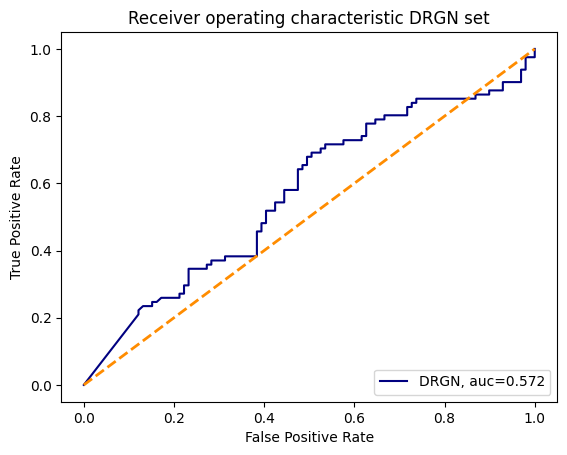

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 6 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 6 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q86YC2 has 5 deleterious and 5 benign samples in training set of 6 Fold 
Protein Q86YC2 has 0 deleterious and 1 benign samples in test set of 6 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 6 Fold 
Protein P01112 has 1 deleterious and 0 benign samples in test set of 6 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P06400 has 13 deleterious and 12 benign samples in training set of 6 Fold 
Protein P06400 has 0 deleterious and 2 benign samples in test set of 6 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P00519 has 12 deleterious and 27 benign

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.8888888888888888
Recall: 0.8888888888888888
F-measure: 0.8888888888888888
----------
Protein P40238 has 9 deleterious and 10 benign samples in training set of 6 Fold 
Protein P40238 has 0 deleterious and 1 benign samples in test set of 6 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P36888 has 25 deleterious and 24 benign samples in training set of 6 Fold 
Protein P36888 has 2 deleterious and 0 benign samples in test set of 6 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P35240 has 7 deleterious and 5 benign samples in training set of 6 Fold 
Protein P35240 has 0 deleterious and 3 benign samples in test set of 6 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein Q92560 has 7 deleterious and 9 benign samples in training set of 6 Fold 
Protein Q92560 has 1 deleterious and 0 benign samples in test set of

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        93
           1       0.58      0.75      0.65        87

    accuracy                           0.61       180
   macro avg       0.62      0.62      0.61       180
weighted avg       0.63      0.61      0.60       180

65 45 48 22
Sensitivity: 74.71
Specificity: 48.39
0.2387984907800959


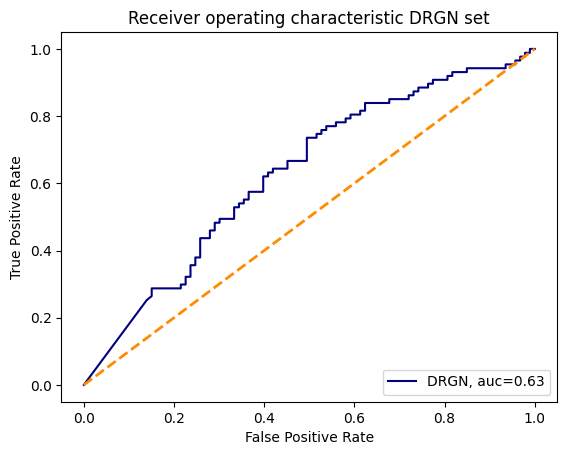

----------
Protein P52701 has 9 deleterious and 9 benign samples in training set of 7 Fold 
Protein P52701 has 0 deleterious and 1 benign samples in test set of 7 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 7 Fold 
Protein Q15831 has 2 deleterious and 0 benign samples in test set of 7 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 7 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 7 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 7 Fold 
Protein P01112 has 1 deleterious and 0 benign samples in test set of 7 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P06400 has 13 deleterious and 13 benign s

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




F-measure: 1.0
----------
Protein Q07812 has 1 deleterious and 1 benign samples in training set of 7 Fold 
Protein Q07812 has 0 deleterious and 1 benign samples in test set of 7 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P35240 has 7 deleterious and 5 benign samples in training set of 7 Fold 
Protein P35240 has 0 deleterious and 2 benign samples in test set of 7 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q06124 has 9 deleterious and 7 benign samples in training set of 7 Fold 
Protein Q06124 has 0 deleterious and 3 benign samples in test set of 7 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P10415 has 0 deleterious and 2 benign samples in training set of 7 Fold 
Protein P10415 has 1 deleterious and 0 benign samples in test set of 7 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.70      0.50      0.59       107
           1       0.49      0.68      0.57        73

    accuracy                           0.58       180
   macro avg       0.59      0.59      0.58       180
weighted avg       0.61      0.58      0.58       180

50 54 53 23
Sensitivity: 68.49
Specificity: 50.47
0.18816453201854771


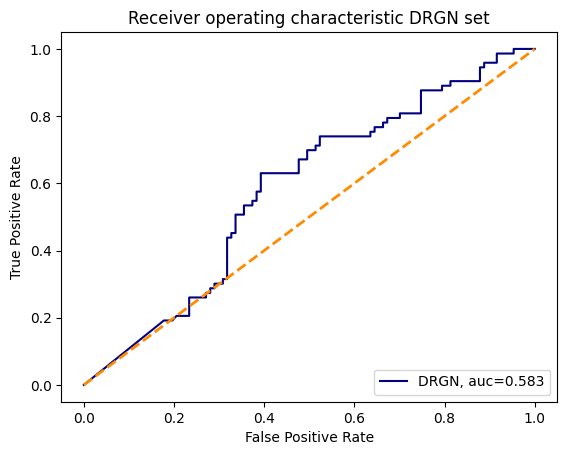

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 8 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 8 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 10 deleterious and 11 benign samples in training set of 8 Fold 
Protein P07333 has 0 deleterious and 3 benign samples in test set of 8 Fold 
Samples for Protein:  3
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P31751 has 5 deleterious and 4 benign samples in training set of 8 Fold 
Protein P31751 has 1 deleterious and 0 benign samples in test set of 8 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P40238 has 9 deleterious and 10 benign samples in training set of 8 Fold 
Protein P40238 has 0 deleterious and 1 benign samples in test set of 8 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P36888 has 26 deleterious and 22 benig

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Protein Q06124 has 0 deleterious and 2 benign samples in test set of 8 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q99062 has 2 deleterious and 2 benign samples in training set of 8 Fold 
Protein Q99062 has 0 deleterious and 1 benign samples in test set of 8 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P35222 has 12 deleterious and 9 benign samples in training set of 8 Fold 
Protein P35222 has 3 deleterious and 1 benign samples in test set of 8 Fold 
Samples for Protein:  4
Precision: 0.25
Recall: 0.25
F-measure: 0.25
----------
Protein P18074 has 16 deleterious and 14 benign samples in training set of 8 Fold 
Protein P18074 has 2 deleterious and 3 benign samples in test set of 8 Fold 
Samples for Protein:  5
Precision: 0.2
Recall: 0.2
F-measure: 0.20000000000000004
----------
Protein P04637 has 94 deleterious and 92 benign samples in training set of 8 Fold 
Protein P04637 has 5 deleterious and

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.62      0.45      0.52        87
           1       0.59      0.74      0.66        93

    accuracy                           0.60       180
   macro avg       0.60      0.60      0.59       180
weighted avg       0.60      0.60      0.59       180

69 39 48 24
Sensitivity: 74.19
Specificity: 44.83
0.19928486356118832


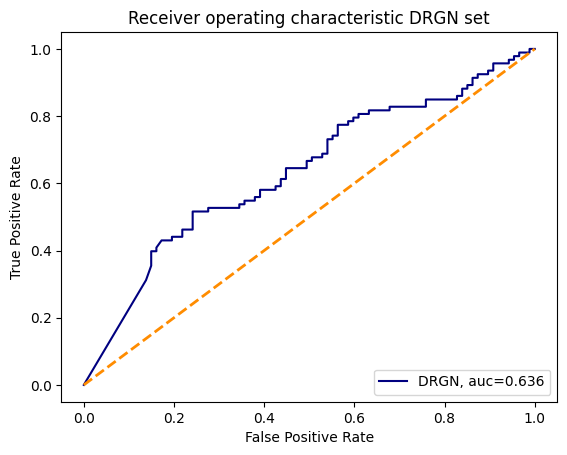

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 9 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 9 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 9 Fold 
Protein P01112 has 1 deleterious and 0 benign samples in test set of 9 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 10 deleterious and 11 benign samples in training set of 9 Fold 
Protein P07333 has 0 deleterious and 3 benign samples in test set of 9 Fold 
Samples for Protein:  3
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P06400 has 12 deleterious and 14 benign samples in training set of 9 Fold 
Protein P06400 has 1 deleterious and 0 benign samples in test set of 9 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P40238 has 9 deleterious and 10 benig

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P36888 has 26 deleterious and 24 benign samples in training set of 9 Fold 
Protein P36888 has 2 deleterious and 0 benign samples in test set of 9 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q92560 has 7 deleterious and 9 benign samples in training set of 9 Fold 
Protein Q92560 has 1 deleterious and 0 benign samples in test set of 9 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 9 Fold 
Protein P35222 has 0 deleterious and 1 benign samples in test set of 9 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P18074 has 18 deleterious and 14 benign samples in training set of 9 Fold 
Protein P18074 has 0 deleterious and 3 benign samples in test set of 9 Fold 
Samples for Protein:  3
Precision: 0.0
Recall: 0.0
F-measure: 0.0
---------

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.75      0.58      0.65       107
           1       0.54      0.71      0.61        73

    accuracy                           0.63       180
   macro avg       0.64      0.65      0.63       180
weighted avg       0.66      0.63      0.64       180

52 62 45 21
Sensitivity: 71.23
Specificity: 57.94
0.2873863211281525


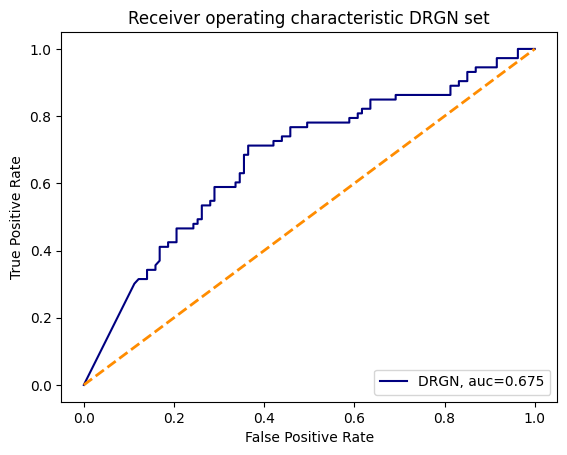

----------
Protein Q13485 has 6 deleterious and 5 benign samples in training set of 10 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 10 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 10 Fold 
Protein Q15831 has 1 deleterious and 1 benign samples in test set of 10 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P16885 has 2 deleterious and 2 benign samples in training set of 10 Fold 
Protein P16885 has 0 deleterious and 2 benign samples in test set of 10 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q96BI1 has 1 deleterious and 2 benign samples in training set of 10 Fold 
Protein Q96BI1 has 0 deleterious and 1 benign samples in test set of 10 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 10 deleterious and 10 

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q15910-4 has 0 deleterious and 3 benign samples in training set of 10 Fold 
Protein Q15910-4 has 0 deleterious and 1 benign samples in test set of 10 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P35240 has 7 deleterious and 6 benign samples in training set of 10 Fold 
Protein P35240 has 0 deleterious and 1 benign samples in test set of 10 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q06124 has 9 deleterious and 7 benign samples in training set of 10 Fold 
Protein Q06124 has 1 deleterious and 1 benign samples in test set of 10 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P10415 has 1 deleterious and 1 benign samples in training set of 10 Fold 
Protein P10415 has 0 deleterious and 1 benign samples in test set of 10 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.65      0.47      0.55       100
           1       0.51      0.69      0.59        80

    accuracy                           0.57       180
   macro avg       0.58      0.58      0.57       180
weighted avg       0.59      0.57      0.56       180

55 47 53 25
Sensitivity: 68.75
Specificity: 47.00
0.15975241260567344


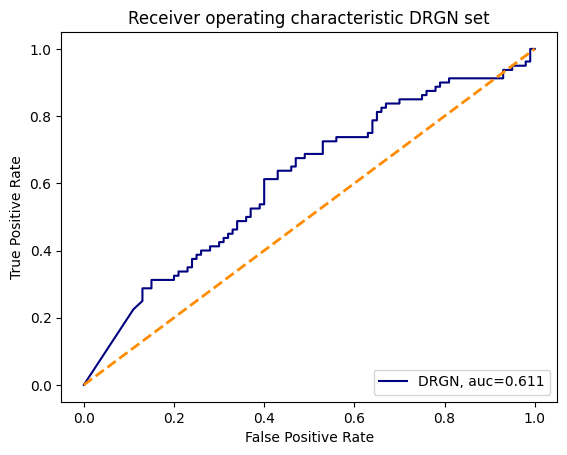

----------
Protein P52701 has 9 deleterious and 9 benign samples in training set of 11 Fold 
Protein P52701 has 0 deleterious and 2 benign samples in test set of 11 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 11 Fold 
Protein Q15831 has 2 deleterious and 0 benign samples in test set of 11 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 11 Fold 
Protein Q13485 has 2 deleterious and 1 benign samples in test set of 11 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein Q96BI1 has 1 deleterious and 1 benign samples in training set of 11 Fold 
Protein Q96BI1 has 0 deleterious and 1 benign samples in test set of 11 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
-------

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Protein Q06124 has 0 deleterious and 3 benign samples in test set of 11 Fold 
Samples for Protein:  3
Precision: 0.3333333333333333
Recall: 0.3333333333333333
F-measure: 0.3333333333333333
----------
Protein Q99062 has 2 deleterious and 3 benign samples in training set of 11 Fold 
Protein Q99062 has 0 deleterious and 2 benign samples in test set of 11 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 11 Fold 
Protein P35222 has 1 deleterious and 0 benign samples in test set of 11 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P04637 has 93 deleterious and 92 benign samples in training set of 11 Fold 
Protein P04637 has 13 deleterious and 1 benign samples in test set of 11 Fold 
Samples for Protein:  14
Precision: 0.5714285714285714
Recall: 0.5714285714285714
F-measure: 0.5714285714285714
----------
Protein P30281 has 5 deleterious and 4

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       100
           1       0.52      0.68      0.59        80

    accuracy                           0.58       180
   macro avg       0.59      0.59      0.58       180
weighted avg       0.60      0.58      0.58       180

54 50 50 26
Sensitivity: 67.50
Specificity: 50.00
0.1760595455030855


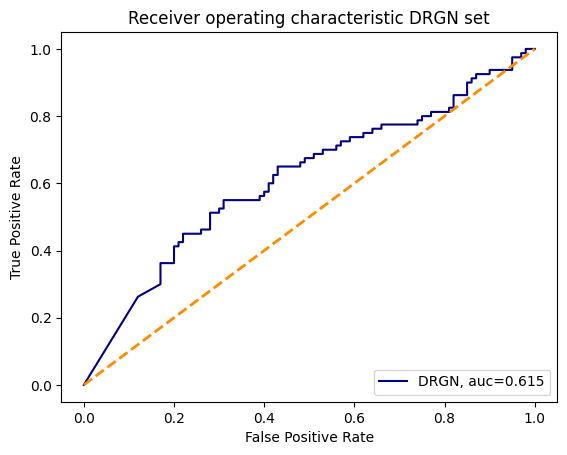

----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 12 Fold 
Protein Q15831 has 1 deleterious and 0 benign samples in test set of 12 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 12 Fold 
Protein Q13485 has 2 deleterious and 1 benign samples in test set of 12 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 12 Fold 
Protein P01112 has 2 deleterious and 0 benign samples in test set of 12 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P06400 has 11 deleterious and 14 benign samples in training set of 12 Fold 
Protein P06400 has 2 deleterious and 0 benign samples in test set of 12 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
-----

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Protein Q99062 has 0 deleterious and 2 benign samples in test set of 12 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 12 Fold 
Protein P35222 has 1 deleterious and 0 benign samples in test set of 12 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P18074 has 15 deleterious and 12 benign samples in training set of 12 Fold 
Protein P18074 has 2 deleterious and 2 benign samples in test set of 12 Fold 
Samples for Protein:  4
Precision: 0.75
Recall: 0.75
F-measure: 0.75
----------
Protein P04637 has 94 deleterious and 92 benign samples in training set of 12 Fold 
Protein P04637 has 4 deleterious and 0 benign samples in test set of 12 Fold 
Samples for Protein:  4
Precision: 0.75
Recall: 0.75
F-measure: 0.75
----------
Protein P30281 has 4 deleterious and 4 benign samples in training set of 12 Fold 
Protein P30281 has 0 deleterious and 1 b

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.68      0.47      0.55        98
           1       0.54      0.73      0.62        82

    accuracy                           0.59       180
   macro avg       0.61      0.60      0.59       180
weighted avg       0.61      0.59      0.58       180

60 46 52 22
Sensitivity: 73.17
Specificity: 46.94
0.20656556475216026


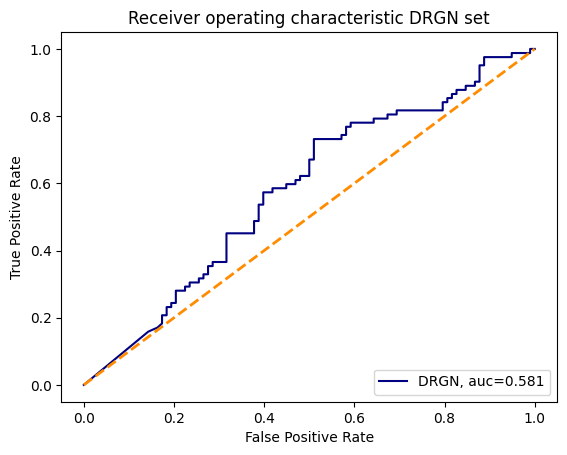

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 13 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 13 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q86YC2 has 5 deleterious and 5 benign samples in training set of 13 Fold 
Protein Q86YC2 has 0 deleterious and 1 benign samples in test set of 13 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 13 Fold 
Protein P01112 has 1 deleterious and 0 benign samples in test set of 13 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 9 deleterious and 9 benign samples in training set of 13 Fold 
Protein P07333 has 1 deleterious and 4 benign samples in test set of 13 Fold 
Samples for Protein:  5
Precision: 0.4
Recall: 0.4
F-measure: 0.4000000000000001
----------
Protein P40238 has 9 delet

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Samples for Protein:  6
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P11309 has 2 deleterious and 3 benign samples in training set of 13 Fold 
Protein P11309 has 1 deleterious and 0 benign samples in test set of 13 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P29992 has 4 deleterious and 2 benign samples in training set of 13 Fold 
Protein P29992 has 1 deleterious and 0 benign samples in test set of 13 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P38398 has 113 deleterious and 117 benign samples in training set of 13 Fold 
Protein P38398 has 8 deleterious and 3 benign samples in test set of 13 Fold 
Samples for Protein:  11
Precision: 0.5454545454545454
Recall: 0.5454545454545454
F-measure: 0.5454545454545454
----------
Protein P49815 has 52 deleterious and 53 benign samples in training set of 13 Fold 
Protein P49815 has 1 deleterious

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.65      0.59      0.62        85
           1       0.66      0.72      0.69        95

    accuracy                           0.66       180
   macro avg       0.65      0.65      0.65       180
weighted avg       0.66      0.66      0.65       180

68 50 35 27
Sensitivity: 71.58
Specificity: 58.82
0.30677238023277215


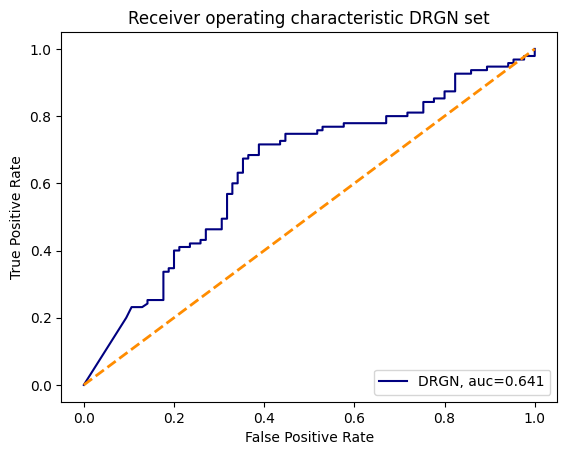

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 14 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 14 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P16885 has 1 deleterious and 3 benign samples in training set of 14 Fold 
Protein P16885 has 1 deleterious and 1 benign samples in test set of 14 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 14 Fold 
Protein P01112 has 2 deleterious and 0 benign samples in test set of 14 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 10 deleterious and 10 benign samples in training set of 14 Fold 
Protein P07333 has 0 deleterious and 1 benign samples in test set of 14 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P06400 has 12 deleterious and 1

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q99062 has 1 deleterious and 3 benign samples in training set of 14 Fold 
Protein Q99062 has 1 deleterious and 1 benign samples in test set of 14 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 14 Fold 
Protein P35222 has 1 deleterious and 0 benign samples in test set of 14 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P04637 has 94 deleterious and 92 benign samples in training set of 14 Fold 
Protein P04637 has 13 deleterious and 0 benign samples in test set of 14 Fold 
Samples for Protein:  13
Precision: 0.9230769230769231
Recall: 0.9230769230769231
F-measure: 0.9230769230769231
----------
Protein P29992 has 4 deleterious and 2 benign samples in training set of 14 Fold 
Protein P29992 has 1 deleterious and 0 benign samples in test set of 14 Fold 
Samples for Protein:  1
P

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.49      0.57       100
           1       0.52      0.70      0.60        80

    accuracy                           0.58       180
   macro avg       0.60      0.59      0.58       180
weighted avg       0.61      0.58      0.58       180

56 49 51 24
Sensitivity: 70.00
Specificity: 49.00
0.19228494197880153


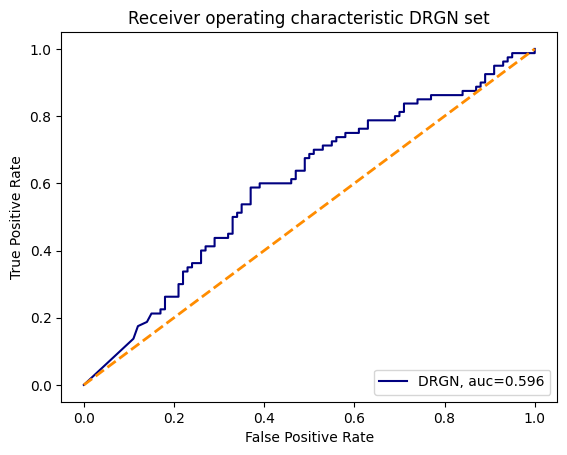

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 15 Fold 
Protein Q13485 has 0 deleterious and 1 benign samples in test set of 15 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q86YC2 has 4 deleterious and 6 benign samples in training set of 15 Fold 
Protein Q86YC2 has 1 deleterious and 1 benign samples in test set of 15 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P07333 has 10 deleterious and 11 benign samples in training set of 15 Fold 
Protein P07333 has 0 deleterious and 1 benign samples in test set of 15 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P06400 has 12 deleterious and 12 benign samples in training set of 15 Fold 
Protein P06400 has 1 deleterious and 2 benign samples in test set of 15 Fold 
Samples for Protein:  3
Precision: 0.3333333333333333
Recall: 0.3333333333333333
F-measure: 0.3333333333333333
---

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P18074 has 18 deleterious and 14 benign samples in training set of 15 Fold 
Protein P18074 has 0 deleterious and 2 benign samples in test set of 15 Fold 
Samples for Protein:  2
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P04637 has 94 deleterious and 92 benign samples in training set of 15 Fold 
Protein P04637 has 7 deleterious and 0 benign samples in test set of 15 Fold 
Samples for Protein:  7
Precision: 0.8571428571428571
Recall: 0.8571428571428571
F-measure: 0.8571428571428571
----------
Protein P11309 has 2 deleterious and 3 benign samples in training set of 15 Fold 
Protein P11309 has 1 deleterious and 0 benign samples in test set of 15 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P49815 has 52 deleterious and 51 benign samples in training set of 15 Fold 
Protein P49815 has 1 deleterious and 5 benign samples in test set of 15 Fold 
Samples for Protein:  6
P

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.61      0.44      0.51        99
           1       0.49      0.65      0.56        81

    accuracy                           0.54       180
   macro avg       0.55      0.55      0.54       180
weighted avg       0.56      0.54      0.54       180

53 44 55 28
Sensitivity: 65.43
Specificity: 44.44
0.10029677042760445


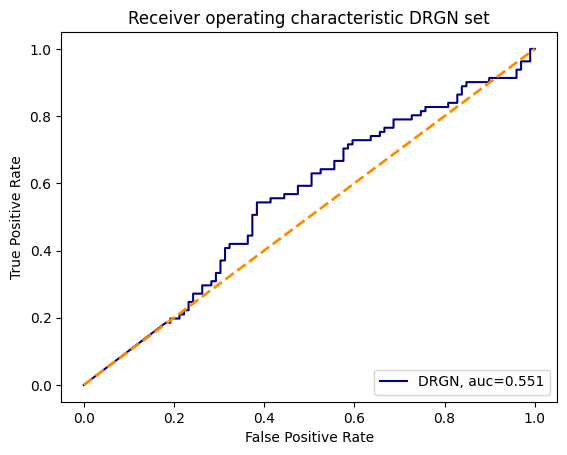

----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 16 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 16 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P16885 has 2 deleterious and 1 benign samples in training set of 16 Fold 
Protein P16885 has 0 deleterious and 2 benign samples in test set of 16 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 9 deleterious and 11 benign samples in training set of 16 Fold 
Protein P07333 has 1 deleterious and 0 benign samples in test set of 16 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P31751 has 6 deleterious and 3 benign samples in training set of 16 Fold 
Protein P31751 has 0 deleterious and 1 benign samples in test set of 16 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P06400 has 12 deleterious and 14

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein Q99062 has 1 deleterious and 3 benign samples in training set of 16 Fold 
Protein Q99062 has 1 deleterious and 1 benign samples in test set of 16 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 16 Fold 
Protein P35222 has 1 deleterious and 0 benign samples in test set of 16 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P18074 has 18 deleterious and 14 benign samples in training set of 16 Fold 
Protein P18074 has 0 deleterious and 4 benign samples in test set of 16 Fold 
Samples for Protein:  4
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P04637 has 93 deleterious and 91 benign samples in training set of 16 Fold 
Protein P04637 has 8 deleterious and 1 benign samples in test set of 16 Fold 
Samples for Protein:  9
Precision: 0.5555555555555556
Recall: 0.555555

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.49      0.56        98
           1       0.54      0.71      0.61        82

    accuracy                           0.59       180
   macro avg       0.60      0.60      0.59       180
weighted avg       0.61      0.59      0.59       180

58 48 50 24
Sensitivity: 70.73
Specificity: 48.98
0.20038125267704918


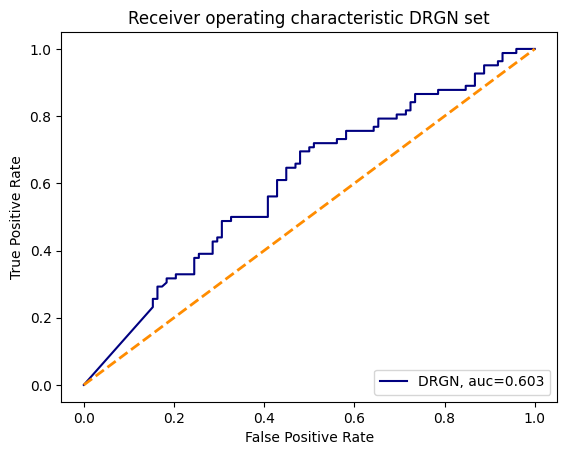

----------
Protein P52701 has 9 deleterious and 10 benign samples in training set of 17 Fold 
Protein P52701 has 2 deleterious and 1 benign samples in test set of 17 Fold 
Samples for Protein:  3
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 17 Fold 
Protein Q15831 has 2 deleterious and 1 benign samples in test set of 17 Fold 
Samples for Protein:  3
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 17 Fold 
Protein Q13485 has 1 deleterious and 1 benign samples in test set of 17 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P01112 has 6 deleterious and 3 benign samples in training set of 17 Fold 
Protein P01112 has 1 deleterious and 0 benign samples in test set of 17 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 10 deleterious and 11

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein Q06124 has 9 deleterious and 7 benign samples in training set of 17 Fold 
Protein Q06124 has 0 deleterious and 1 benign samples in test set of 17 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q93074 has 3 deleterious and 5 benign samples in training set of 17 Fold 
Protein Q93074 has 1 deleterious and 0 benign samples in test set of 17 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 17 Fold 
Protein P35222 has 2 deleterious and 0 benign samples in test set of 17 Fold 
Samples for Protein:  2
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P18074 has 18 deleterious and 13 benign samples in training set of 17 Fold 
Protein P18074 has 0 deleterious and 3 benign samples in test set of 17 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.66666666

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.54      0.57        91
           1       0.58      0.64      0.61        89

    accuracy                           0.59       180
   macro avg       0.59      0.59      0.59       180
weighted avg       0.59      0.59      0.59       180

57 49 42 32
Sensitivity: 64.04
Specificity: 53.85
0.17980119724495086


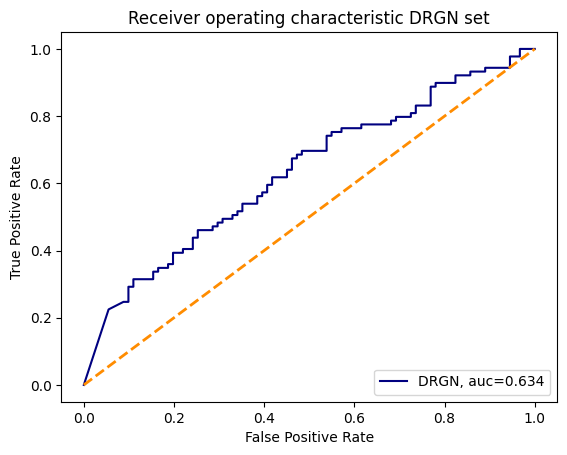

----------
Protein Q15831 has 5 deleterious and 3 benign samples in training set of 18 Fold 
Protein Q15831 has 0 deleterious and 1 benign samples in test set of 18 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein Q13485 has 7 deleterious and 5 benign samples in training set of 18 Fold 
Protein Q13485 has 1 deleterious and 0 benign samples in test set of 18 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P16885 has 1 deleterious and 3 benign samples in training set of 18 Fold 
Protein P16885 has 1 deleterious and 0 benign samples in test set of 18 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P01106 has 2 deleterious and 3 benign samples in training set of 18 Fold 
Protein P01106 has 0 deleterious and 1 benign samples in test set of 18 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P07333 has 9 deleterious and 10 b

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P38398-4 has 1 deleterious and 1 benign samples in training set of 18 Fold 
Protein P38398-4 has 2 deleterious and 0 benign samples in test set of 18 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 18 Fold 
Protein P35222 has 3 deleterious and 0 benign samples in test set of 18 Fold 
Samples for Protein:  3
Precision: 0.3333333333333333
Recall: 0.3333333333333333
F-measure: 0.3333333333333333
----------
Protein P18074 has 17 deleterious and 14 benign samples in training set of 18 Fold 
Protein P18074 has 2 deleterious and 1 benign samples in test set of 18 Fold 
Samples for Protein:  3
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F-measure: 0.6666666666666666
----------
Protein P04637 has 94 deleterious and 92 benign samples in training set of 18 Fold 
Protein P04637 has 6 deleterious and 1 benign samples 

  0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.57      0.49      0.53        88
           1       0.57      0.65      0.61        92

    accuracy                           0.57       180
   macro avg       0.57      0.57      0.57       180
weighted avg       0.57      0.57      0.57       180

60 43 45 32
Sensitivity: 65.22
Specificity: 48.86
0.14277241982338443


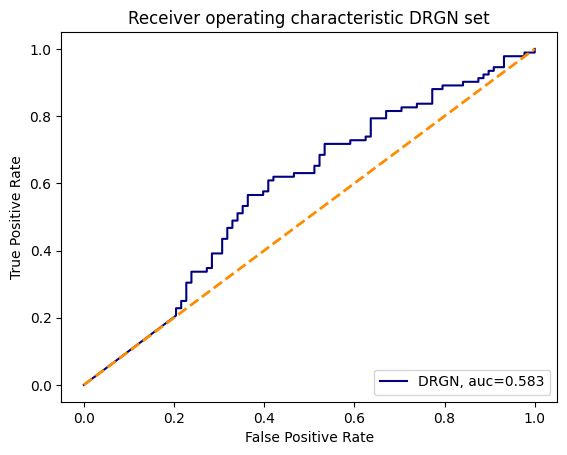

----------
Protein P36888 has 26 deleterious and 21 benign samples in training set of 19 Fold 
Protein P36888 has 2 deleterious and 1 benign samples in test set of 19 Fold 
Samples for Protein:  3
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P38398-4 has 1 deleterious and 1 benign samples in training set of 19 Fold 
Protein P38398-4 has 1 deleterious and 0 benign samples in test set of 19 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P35222 has 12 deleterious and 10 benign samples in training set of 19 Fold 
Protein P35222 has 1 deleterious and 0 benign samples in test set of 19 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P04198 has 5 deleterious and 5 benign samples in training set of 19 Fold 
Protein P04198 has 0 deleterious and 1 benign samples in test set of 19 Fold 
Samples for Protein:  1
Precision: 0.0
Recall: 0.0
F-measure: 0.0
----------
Protein P60484 has 14 deleterious

<ipython-input-23-315bab4cb8d9>:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-315bab4cb8d9>:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Protein P46527 has 1 deleterious and 1 benign samples in test set of 19 Fold 
Samples for Protein:  2
Precision: 0.5
Recall: 0.5
F-measure: 0.5
----------
Protein P11802 has 5 deleterious and 4 benign samples in training set of 19 Fold 
Protein P11802 has 1 deleterious and 0 benign samples in test set of 19 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P25445 has 3 deleterious and 4 benign samples in training set of 19 Fold 
Protein P25445 has 0 deleterious and 2 benign samples in test set of 19 Fold 
Samples for Protein:  2
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P08581 has 4 deleterious and 29 benign samples in training set of 19 Fold 
Protein P08581 has 0 deleterious and 1 benign samples in test set of 19 Fold 
Samples for Protein:  1
Precision: 1.0
Recall: 1.0
F-measure: 1.0
----------
Protein P43246 has 13 deleterious and 14 benign samples in training set of 19 Fold 
Protein P43246 has 2 deleterious and 1 benign sam

In [ ]:
# Distribution of proteins in trianing / test se tof fold
# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs=200
lr = [3e-5]
#h = 1024
#h = 2048
h = 4096
#hidden2 =258
#hidden2=1024
hidden2=2048
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 20

accuracy, sensitivity, specificity, mcc, auc_dict = {}, {}, {}, {}, {}

for fold in range(n_folds):
  test = dif_mut_drgn_shuffled[fold*round(len(dif_mut_drgn_shuffled)/n_folds):(fold+1)*round(len(dif_mut_drgn_shuffled)/n_folds)]
  temp = test.mutation.str.split(pat='_',expand=True)[0]


  stacked_flat_drgn =[]
  for i, mut in test.iterrows():
    stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

  stacked_drgn = torch.stack(stacked_flat_drgn)
  print(stacked_drgn.shape)

  cond = dif_mut_shuffled['mutation'].isin(test['mutation'])
  training = dif_mut_shuffled.drop(dif_mut_shuffled[cond].index, inplace = False)

  #print('deleterious labels in Training for Fold ', fold, ': ', len(training[training['label']==1]))
  #print('benign labels in Training for Fold ', fold, ': ',  len(training[training['label']==0]))

  #print('deleterious labels in Test for Fold ', fold, ': ', len(test[test['label']==1]))
  #print('benign labels in Test for Fold ', fold, ': ',  len(test[test['label']==0]))
  #print('different genes in Fold ', fold, ': ',  len(temp.unique()))


  # exclude test mutations from training data
  stacked_flat =[]
  for i, mut in training.iterrows():
    stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

  stacked_gmm = torch.stack(stacked_flat)
  print(stacked_gmm.shape)

  training_temp = training.mutation.str.split(pat='_',expand=True)

  # how many proteins co exist in training set / test set
  prot_inters= intersection(training_temp[0].unique(), temp.unique())
  print('Proteins in common between training set / test set: ', len(prot_inters))#, ': ', prot_inters)
  '''
  # how many deleterious / benign per protein are in training versus test set
  for prot_int in prot_inters:
    training_df = training[training['mutation'].str.contains(prot_int)]
    del_training = len(training_df[training_df['label'] == 1])
    ben_training = len(training_df[training_df['label'] == 0])

    test_df =  test[test['mutation'].str.contains(prot_int)]
    del_test = len(test_df[test_df['label'] == 1])
    ben_test = len(test_df[test_df['label'] == 0])

    # creating the dataset
    data = {'Train del':del_training, 'Train ben':ben_training, 'Test del':del_test, 'Test ben':ben_test}
    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (5, 3))

    # creating the bar plot
    plt.bar(courses, values, color ='maroon',
            width = 0.4)

    plt.xlabel("")
    plt.ylabel("No. of samples")
    plt.title(prot_int)
    plt.xticks(rotation=45)
    plt.show()

  '''
  # seperate inputs and outputs
  X = stacked_gmm
  y = training['label']

  # Split, shuffle and stratify sequences, mutations, proteins and label
  X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, training_temp[1],  training_temp[0], test_size=0.0002, stratify=y, random_state=69)
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_test, y_test = np.array(X_test), np.array(y_test)

  del stacked_gmm, X
  gc.collect()

  train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
  val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

  #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))# Train
  #sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
  #sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

  train_loader = DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=2, drop_last=True)

  my_net = Classifier2L(h, hidden2, 0.3).to(device)
  #my_net = my_net = Classifier(h, 0.3).to(device)
  my_net.apply(init_weights)
  param_optimizer = list(my_net.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.02,
      },
  ]

  num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
  optimizer = torch.optim.AdamW(optimizer_parameters, lr=3e-5)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=1000, num_training_steps=num_train_steps
  )

  loss, acc = train_net_cross(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler )


  labels_drgn = test['label'].tolist()
  X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)

  drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
  drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)


  y_pred_list = []
  predictions_drgn= []
  my_net.eval()

  with torch.no_grad():
      for X_batch, _ in drgn_loader:
          X_batch = X_batch.to(device)
          y_test_pred = my_net(X_batch)
          #print(y_test_pred)
          predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
          #print(predictions_drgn)

  flat_list = []
  for sublist in predictions_drgn:
      for item in sublist:
          flat_list.append(item)

  predictions_drgn = [1 if i>=0.5 else 0 for i in flat_list]
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn))
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn).ravel()
  print(classification_report(y_drgn, predictions_drgn))
  print(tp, tn, fp, fn)
  TPR =tp / (tp + fn)
  print('Sensitivity: %.2f'  % (TPR*100))

  TNR = tn / (tn + fp)
  print('Specificity: %.2f'  % (TNR*100))
  print(matthews_corrcoef(y_drgn, predictions_drgn))

  lw = 2
  import matplotlib
  matplotlib.rc_file_defaults()
  fpr, tpr, _ = metrics.roc_curve(y_drgn[:len(predictions_drgn)],  flat_list)
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn)], flat_list)
  plt.plot(fpr,tpr,color="navy",label="DRGN, auc="+str(round(auc, 3)))
  plt.plot([0, 1], [0, 1], color="darkorange", lw=lw, linestyle="--")
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic DRGN set")
  plt.rcParams["figure.figsize"] = (10,10)
  plt.show()

  accuracy[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity[fold]=TPR*100
  specificity[fold]=TNR*100
  mcc[fold]= matthews_corrcoef(y_drgn, predictions_drgn)*100
  auc_dict[fold] =round(auc, 3)*100

  # find the accuracy per protein
  test['Groundtruth'] = y_drgn
  test['prediction'] = predictions_drgn

  training_df = pd.DataFrame(list(zip(prot_all_train.tolist(), y_train.tolist())),
               columns =['uniprot', 'label'])
  for prot_int in prot_inters:

    print('----------')

    df = training_df[training_df['uniprot']==prot_int]
    del_training = len(df[df['label'] == 1])
    ben_training = len(df[df['label'] == 0])
    print(f'Protein {prot_int} has {del_training} deleterious and {ben_training} benign samples in training set of {fold} Fold ')
    test_accu = test[test['mutation'].str.contains(prot_int)]
    del_test_accu = len(test_accu[test_accu['label'] == 1])
    ben_test_accu = len(test_accu[test_accu['label'] == 0])
    print(f'Protein {prot_int} has {del_test_accu} deleterious and {ben_test_accu} benign samples in test set of {fold} Fold ')

    print('Samples for Protein: ', len(test_accu))
    #print(classification_report(test_accu['Groundtruth'], test_accu['prediction']))
    precision, recall, fscore, support = precision_recall_fscore_support(test_accu['Groundtruth'], test_accu['prediction'], average='micro')#, pos_label=1)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-measure: {}'.format(fscore))

In [ ]:
ds=[accuracy,  sensitivity,  specificity,  mcc, auc_dict]
test = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

test['metric'] = ['accuracy']* len(accuracy) + ['sensitivity']* len(accuracy)+  ['specificity']* len(accuracy)+  ['mcc']* len(accuracy)+ ['AUC']* len(accuracy)
test['fold'] = fold_list
test['value'] = value_list

fig = px.violin(test, y="metric", x="value", color="metric", box=True, points="all", width=800, height=400, title="20 folds")
fig.show()

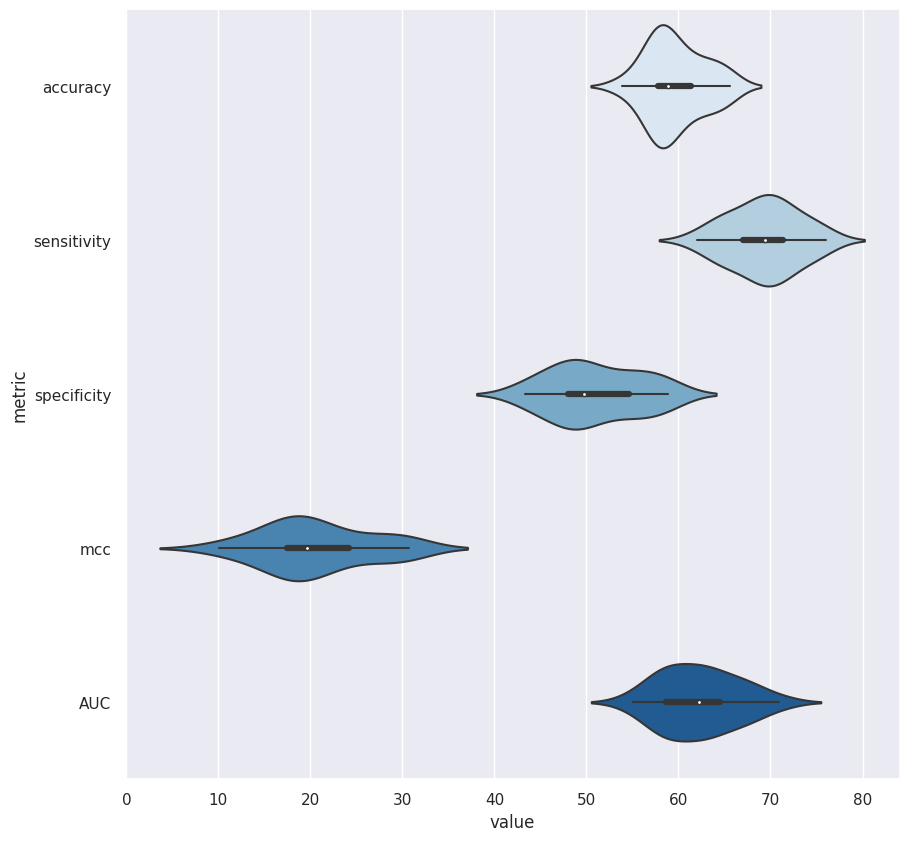

In [ ]:
sns.set(style="darkgrid")
sns.violinplot(data=test, x="value", y="metric", palette="Blues")
plt.show()

# Cross-validation DRGN with results of all predictors

In [ ]:
# implementation of a single training epoch
def train_epoch_cross(net, loader, loss_fn, optimizer, scheduler):

    # set the network in training mode
    net.train()

    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct = 0
    targets = []
    predictions = []

    for i, data in enumerate(loader):

        # sample data
        x, y = data
        x = x.to(device)
        y = y.to(device)

        # set all gradients equal to zero
        net.zero_grad()

        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        #y_pred_sq = np.squeeze(y_pred) # add when using loss_fn: BCEloss()

        pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        #correct_tensor = pred.eq(y.float().view_as(pred))
        #correct = np.squeeze(correct_tensor.cpu().numpy())
        #num_correct += np.sum(correct)
        targets.extend(y.cpu().detach().numpy().tolist())
        predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

        #predictions_round = [round(p) for p in predictions]
        #correct_tensor = predictions_round.eq(targets.float().view_as(predictions_round))

        #loss = loss_fn(y_pred_sq, y.float())  #add when using loss_fn: BCEloss()
        loss = loss_fn(y_pred, y.float())

        # Specify L1 and L2 weights
        l1_weight = 0
        l2_weight = 0

        # Compute L1 and L2 loss component
        parameters = []
        for parameter in net.parameters():
            parameters.append(parameter.view(-1))
        l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))

        # Add L1 and L2 loss components
        loss += l1
        loss += l2

        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
        scheduler.step()

        #break #for training one batch

    # compute the average loss
    #mytrain_acc = num_correct
    loss_avg = loss_cum / cnt

    #predictions = np.array(predictions) >= 0.5
    predictions = [1 if p[0] > 0.5 else 0 for p in predictions]
    mytrain_acc  = metrics.accuracy_score(targets, predictions)   *100
    #mytrain_acc = (num_correct/ (len(y)*cnt)) *100
    return loss_avg, mytrain_acc

def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

In [ ]:
def train_net_cross(net, train_loader, val_loader, loss_fn, optimizer, epochs , scheduler):

    # transfer the network to the GPU
    net = net.to(device)

    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    train_acc_alt = np.zeros((epochs))

    test_acc = np.zeros((epochs))
    test_acc_alt = np.zeros((epochs))

    print("Begin training.")

    for epoch in tqdm(range(epochs)):

        # training
        train_loss[epoch], train_acc[epoch] = train_epoch_cross(net, train_loader, loss_fn, optimizer, scheduler)
        #predictions, outputs = eval(net, train_loader)
        #train_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)

        # validation
        test_loss[epoch], test_acc[epoch] = test_epoch(net, val_loader, loss_fn)
        #predictions, outputs = eval(net, val_loader)
        #test_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)

        #print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f'
        #     % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

        #print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f'
        #    % (epoch, train_loss[epoch], train_acc[epoch]))# for training one batch

    return (train_loss, test_loss), (train_acc , test_acc)
    #return train_loss, train_acc # for training one batch

## Train / test only ones with overlapping values for all predictors

### Import training data

In [ ]:
# import difference for each mutation + labels
dif_mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_common_balanced+-2_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# exclude duplicates
#dif_mut.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut[dif_mut['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut[dif_mut['label'] == 0]))


# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut['fl_dif_pad'] = fl_dif_pad
dif_mut_shuffled = dif_mut.sample(frac=1)

Deleterious mutations in dataset:  2956
Benign mutations in dataset:  3652


### Import results of all predictors for DRGN and save them in dictionary

In [ ]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_012023_DEOGEN_etc.csv')
# squeeze proteins and mutaitons in one column
df['mutation'] = df['uniprot'] + '_' + df['AA_orig'] + df['position'].astype(str) + df['AA_targ']
df = df.drop(columns=['label'])
# Create a dictionary with the specified columns as key and values
results_all = {}
for key, val1, val2, val3, val4, val5 in zip(df['mutation'], df['DEOGEN2'], df['EVE'], df['FATHMM'], df['SIFT'], df['PolyPhen2']):
    #if key in my_dict: # should be the case since I dont have duplicates
    #    my_dict[key].append([val1, val2, val3, val4, val5])
    #else:
    results_all[key] = [val1, val2, val3, val4, val5]

## keep only the values that have prediction for all predictors
df = df[~df.isnull().any(axis=1)]

### Import testing data (DRGN) representations

In [ ]:
dif_mut_drgn = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_DRGN_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
# exclude duplicates
#dif_mut_drgn.drop_duplicates(subset = 'mutation', inplace =True)

dif_mut_drgn_nonan = pd.merge(df, dif_mut_drgn, how='inner', on=['mutation']) # Ti einai auto?? Giati den grafeis sxolia ????? Ok katalaba: Exairw ta DRGN samples pou den exw timi gia olous tous predictors
print(len(dif_mut_drgn_nonan))

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn_nonan['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn_nonan['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn_nonan[dif_mut_drgn_nonan['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn_nonan[dif_mut_drgn_nonan['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn_nonan.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn_nonan['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn_nonan.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

dif_mut_drgn_shuffled = dif_mut_drgn_nonan.sample(frac=1)

1868
Deleterious mutations in dataset:  878
Benign mutations in dataset:  990


### Train / test only ones with overlapping values for all predictors


In [ ]:
# Distribution of proteins in trianing / test se tof fold
# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs=200
lr = [3e-5]
h = 4096
hidden2=2048
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 5

sensitivity_D2D, specificity_D2D, mcc_D2D, auc_D2D = {}, {}, {}, {}
sensitivity_DEOGEN2, specificity_DEOGEN2, mcc_DEOGEN2, auc_DEOGEN2 = {}, {}, {}, {}
sensitivity_EVE, specificity_EVE, mcc_EVE, auc_EVE = {}, {}, {}, {}
sensitivity_FATHMM, specificity_FATHMM, mcc_FATHMM, auc_FATHMM = {}, {}, {}, {}
sensitivity_SIFT, specificity_SIFT, mcc_SIFT, auc_SIFT = {}, {}, {}, {}
sensitivity_PolyPhen2, specificity_PolyPhen2, mcc_PolyPhen2, auc_PolyPhen2 = {}, {}, {}, {}

for fold in range(n_folds):
  print(f'Starting {fold} fold')
  test = dif_mut_drgn_shuffled[fold*round(len(dif_mut_drgn_shuffled)/n_folds):(fold+1)*round(len(dif_mut_drgn_shuffled)/n_folds)]
  temp = test.mutation.str.split(pat='_',expand=True)[0]

  stacked_flat_drgn =[]
  for i, mut in test.iterrows():
    stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

  stacked_drgn = torch.stack(stacked_flat_drgn)
  print('Test set dimensions of fold: ', stacked_drgn.shape)

  cond = dif_mut_shuffled['mutation'].isin(test['mutation'])
  training = dif_mut_shuffled.drop(dif_mut_shuffled[cond].index, inplace = False)

  # exclude test mutations from training data
  stacked_flat =[]
  for i, mut in training.iterrows():
    stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

  stacked_gmm = torch.stack(stacked_flat)
  print('Training set dimensions of fold: ', stacked_gmm.shape)

  training_temp = training.mutation.str.split(pat='_',expand=True)

  # seperate inputs and outputs
  X = stacked_gmm
  y = training['label']

  # Split, shuffle and stratify sequences, mutations, proteins and label
  X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, training_temp[1],  training_temp[0], test_size=0.0002, stratify=y, random_state=69)
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_test, y_test = np.array(X_test), np.array(y_test)

  del stacked_gmm, X
  gc.collect()

  train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
  val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

  train_loader = DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=2, drop_last=True)

  my_net = Classifier2L(h, hidden2, 0.3).to(device)
  my_net.apply(init_weights)
  param_optimizer = list(my_net.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.02,
      },
  ]

  num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
  optimizer = torch.optim.AdamW(optimizer_parameters, lr=3e-5)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=num_train_steps)

  loss, acc = train_net_cross(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler )
  labels_drgn = test['label'].tolist()
  X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)  # Actual test

  drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
  drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

  y_pred_list = []
  predictions_drgn= []
  my_net.eval()

  with torch.no_grad():
      for X_batch, _ in drgn_loader:
          X_batch = X_batch.to(device)
          y_test_pred = my_net(X_batch)
          predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

  flat_list = []
  for sublist in predictions_drgn:
      for item in sublist:
          flat_list.append(item)

  predictions_drgn_D2D = [1 if i>=0.5 else 0 for i in flat_list]
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_D2D))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_D2D)], flat_list)
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_D2D).ravel()
  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_D2D[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_D2D[fold]=TPR*100
  specificity_D2D[fold]=TNR*100
  mcc_D2D[fold]= matthews_corrcoef(y_drgn, predictions_drgn_D2D)*100
  auc_D2D[fold] =round(auc, 3)*100


  # DEOGEN2 results for fold
  DEOGEN2_drgn = []
  for mut_tet in test['mutation'].values:
    DEOGEN2_drgn.append(results_all[mut_tet][0])

  ## use when NA --> errors
  DEOGEN2_drgn_Na = []
  for j,i in enumerate(DEOGEN2_drgn):
    if notNaN(i): # if not NaN
      DEOGEN2_drgn_Na.append(i)
    else:
      DEOGEN2_drgn_Na.append(1- y_drgn[j])
  predictions_drgn_DEOGEN2 = [1 if i>0.5 else 0 for i in DEOGEN2_drgn_Na]

  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_DEOGEN2))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_DEOGEN2)], DEOGEN2_drgn_Na )
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_DEOGEN2).ravel()

  ## use when NA --> omit
  #y_drgn_DEOGEN2 = [x for x, y in zip(y_drgn, DEOGEN2_drgn) if not pd.isna(y)]
  #predictions_drgn_DEOGEN2 = [x for x in DEOGEN2_drgn if not pd.isna(x)]
  #predictions_drgn_DEOGEN2 = [1 if i>0.5 else 0 for i in predictions_drgn_DEOGEN2]
  #confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_DEOGEN2, predictions_drgn_DEOGEN2))
  #auc = metrics.roc_auc_score(y_drgn_DEOGEN2[:len(predictions_drgn_DEOGEN2)], predictions_drgn_DEOGEN2 )
  #tn, fp, fn, tp = confusion_matrix(y_drgn_DEOGEN2, predictions_drgn_DEOGEN2).ravel()

  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_DEOGEN2[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_DEOGEN2[fold]=TPR*100
  specificity_DEOGEN2[fold]=TNR*100
  mcc_DEOGEN2[fold]= matthews_corrcoef(y_drgn, predictions_drgn_DEOGEN2)*100 # y_drgn_DEOGEN2 when omit
  auc_DEOGEN2[fold] =round(auc, 3)*100


  # EVE results for fold
  EVE_drgn = []
  for mut_tet in test['mutation'].values:
    EVE_drgn.append(results_all[mut_tet][1])

  # use when NA --> errors
  #EVE_drgn_Na = []
  #for j,i in enumerate(EVE_drgn):
  #  if notNaN(i): # if not NaN
  #    if i>=0.63:
  #      temp.append(1)
  #    elif i<0.38:
   #     temp.append(0)
   # else:
   #   EVE_drgn_Na.append(1- y_drgn[j])
  #predictions_drgn_EVE = [1 if i>=0.5 else 0 for i in EVE_drgn_Na ]
  temp=[]
  for i in EVE_drgn:
    if i<=0.62 and i>=0.5:
      temp.append(i-0.13)
    elif i>=0.38 and i<0.5:
      temp.append(i+0.17)
    else:
      temp.append(i)
  predictions_drgn_EVE = [1 if i>0.5 else 0 for i in temp]
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_EVE))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_EVE)], temp) # EVE_drgn_Na
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_EVE).ravel()

  # use when NA --> omit
  #y_drgn_EVE = [x for x, y in zip(y_drgn, EVE_drgn) if not pd.isna(y)]
  #predictions_drgn_EVE = [x for x in EVE_drgn if not pd.isna(x)]
  #temp = []
  #for j,i in enumerate(predictions_drgn_EVE):
  #  if i>=0.63:
  #    temp.append(1)
  #  elif i<0.38:
  #    temp.append(0)
  #  else:
  #    temp.append(1- y_drgn[j])
  #predictions_drgn_EVE = temp
  #confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_EVE, predictions_drgn_EVE))
  #auc = metrics.roc_auc_score(y_drgn_EVE[:len(predictions_drgn_EVE)], predictions_drgn_EVE) # EVE_drgn_Na
  #tn, fp, fn, tp = confusion_matrix(y_drgn_EVE, predictions_drgn_EVE).ravel()

  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_EVE[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_EVE[fold]=TPR*100
  specificity_EVE[fold]=TNR*100
  mcc_EVE[fold]= matthews_corrcoef(y_drgn, predictions_drgn_EVE)*100 # y_drgn_EVE when omit
  auc_EVE[fold] =round(auc, 3)*100

  # FATHMM results for fold
  FATHMM_drgn = []
  for mut_tet in test['mutation'].values:
    FATHMM_drgn.append(results_all[mut_tet][2])
  # use when NA --> errors
  #FATHMM_drgn_Na = []
  #for j,i in enumerate(FATHMM_drgn):
  #  if notNaN(i): # if not NaN
  #    FATHMM_drgn_Na.append(i)
  #  else:
  #    FATHMM_drgn_Na.append(1- y_drgn[j])
  #predictions_drgn_FATHMM = [1 if i<-0.75 else 0 for i in FATHMM_drgn_Na ]

  # use when NA --> omit
  y_drgn_FATHMM = [x for x, y in zip(y_drgn, FATHMM_drgn) if not pd.isna(y)]
  predictions_drgn_FATHMM = [x for x in FATHMM_drgn if not pd.isna(x)]
  predictions_drgn_FATHMM = [1 if i<-0.75 else 0 for i in predictions_drgn_FATHMM]

  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_FATHMM, predictions_drgn_FATHMM))
  auc = metrics.roc_auc_score(y_drgn_FATHMM[:len(predictions_drgn_FATHMM)], predictions_drgn_FATHMM ) # FATHMM_drgn_Na
  tn, fp, fn, tp = confusion_matrix(y_drgn_FATHMM, predictions_drgn_FATHMM).ravel()
  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_FATHMM[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_FATHMM[fold]=TPR*100
  specificity_FATHMM[fold]=TNR*100
  mcc_FATHMM[fold]= matthews_corrcoef(y_drgn_FATHMM, predictions_drgn_FATHMM)*100
  auc_FATHMM[fold] =round(auc, 3)*100


  # SIFT results for fold
  SIFT_drgn = []
  for mut_tet in test['mutation'].values:
    SIFT_drgn.append(results_all[mut_tet][3])

  # use when NA --> errors
  #SIFT_drgn_Na = []
  #for j,i in enumerate(SIFT_drgn):
  #  if notNaN(i): # if not NaN
  #    SIFT_drgn_Na.append(i)
  #  else:
  #    SIFT_drgn_Na.append(1- y_drgn[j])
  #predictions_drgn_SIFT = [1 if i<=0.05 else 0 for i in SIFT_drgn_Na ]

  # use when NA --> omit
  y_drgn_SIFT = [x for x, y in zip(y_drgn, SIFT_drgn) if not pd.isna(y)]
  predictions_drgn_SIFT = [x for x in SIFT_drgn if not pd.isna(x)]
  predictions_drgn_SIFT = [1 if i<=0.05 else 0 for i in predictions_drgn_SIFT]

  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_SIFT, predictions_drgn_SIFT))
  auc = metrics.roc_auc_score(y_drgn_SIFT[:len(predictions_drgn_SIFT)], predictions_drgn_SIFT ) #SIFT_drgn_Na
  tn, fp, fn, tp = confusion_matrix(y_drgn_SIFT, predictions_drgn_SIFT).ravel()
  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_SIFT[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_SIFT[fold]=TPR*100
  specificity_SIFT[fold]=TNR*100
  mcc_SIFT[fold]= matthews_corrcoef(y_drgn_SIFT, predictions_drgn_SIFT)*100
  auc_SIFT[fold] =round(auc, 3)*100


  # PolyPhen2 results for fold
  PolyPhen2_drgn = []
  for mut_tet in test['mutation'].values:
    PolyPhen2_drgn.append(results_all[mut_tet][4])

  # use when NA --> errors
  #PolyPhen2_drgn_Na = []
  #for j,i in enumerate(PolyPhen2_drgn):
  #  if notNaN(i): # if not NaN
  #    PolyPhen2_drgn_Na.append(i)
  #  else:
  #    PolyPhen2_drgn_Na.append(1- y_drgn[j])
  #predictions_drgn_PolyPhen2 = [1 if i>=0.49 else 0 for i in PolyPhen2_drgn_Na]

  # use when NA --> omit
  y_drgn_PolyPhen2 = [x for x, y in zip(y_drgn, PolyPhen2_drgn) if not pd.isna(y)]
  predictions_drgn_PolyPhen2 = [x for x in PolyPhen2_drgn if not pd.isna(x)]
  predictions_drgn_PolyPhen2 = [1 if i>=0.49 else 0 for i in predictions_drgn_PolyPhen2]
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_PolyPhen2, predictions_drgn_PolyPhen2))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_PolyPhen2)],predictions_drgn_PolyPhen2 ) # PolyPhen2_drgn_Na
  tn, fp, fn, tp = confusion_matrix(y_drgn_PolyPhen2, predictions_drgn_PolyPhen2).ravel()
  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_PolyPhen2[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_PolyPhen2[fold]=TPR*100
  specificity_PolyPhen2[fold]=TNR*100
  mcc_PolyPhen2[fold]= matthews_corrcoef(y_drgn_PolyPhen2, predictions_drgn_PolyPhen2)*100
  auc_PolyPhen2[fold] =round(auc, 3)*100

Starting 0 fold
Test set dimensions of fold:  torch.Size([374, 2200])
Training set dimensions of fold:  torch.Size([6494, 2200])
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.731837 - Train accuracy: 57.271040 - Test loss: 0.661854 - Test accuracy: 50.000000
Epoch     1 - Train loss: 0.605136 - Train accuracy: 70.560025 - Test loss: 0.654686 - Test accuracy: 50.000000
Epoch     2 - Train loss: 0.587654 - Train accuracy: 71.055074 - Test loss: 0.629708 - Test accuracy: 50.000000
Epoch     3 - Train loss: 0.564693 - Train accuracy: 72.540223 - Test loss: 0.578186 - Test accuracy: 50.000000
Epoch     4 - Train loss: 0.546649 - Train accuracy: 73.777847 - Test loss: 0.604261 - Test accuracy: 50.000000
Epoch     5 - Train loss: 0.524940 - Train accuracy: 74.953589 - Test loss: 0.604421 - Test accuracy: 50.000000
Epoch     6 - Train loss: 0.508968 - Train accuracy: 76.175743 - Test loss: 0.622812 - Test accuracy: 50.000000
Epoch     7 - Train loss: 0.481558 - Train accuracy: 77.645421 - Test loss: 0.640450 - Test accuracy: 50.000000
Epoch     8 - Train loss: 0.467002 - Train accuracy: 78.666460 - Test loss: 0.652513 - Test accuracy: 50

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.731794 - Train accuracy: 52.552599 - Test loss: 1.054378 - Test accuracy: 0.000000
Epoch     1 - Train loss: 0.619671 - Train accuracy: 70.482673 - Test loss: 1.177867 - Test accuracy: 0.000000
Epoch     2 - Train loss: 0.601291 - Train accuracy: 71.240718 - Test loss: 1.246937 - Test accuracy: 0.000000
Epoch     3 - Train loss: 0.565329 - Train accuracy: 72.973391 - Test loss: 1.273577 - Test accuracy: 0.000000
Epoch     4 - Train loss: 0.558158 - Train accuracy: 72.447401 - Test loss: 1.234243 - Test accuracy: 0.000000
Epoch     5 - Train loss: 0.533002 - Train accuracy: 75.185644 - Test loss: 1.273260 - Test accuracy: 0.000000
Epoch     6 - Train loss: 0.506226 - Train accuracy: 76.113861 - Test loss: 1.232041 - Test accuracy: 0.000000
Epoch     7 - Train loss: 0.478044 - Train accuracy: 78.016708 - Test loss: 1.228059 - Test accuracy: 0.000000
Epoch     8 - Train loss: 0.469408 - Train accuracy: 78.372525 - Test loss: 1.204490 - Test accuracy: 0.000000
E

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.700595 - Train accuracy: 63.010520 - Test loss: 0.267538 - Test accuracy: 100.000000
Epoch     1 - Train loss: 0.618275 - Train accuracy: 69.894802 - Test loss: 0.201064 - Test accuracy: 100.000000
Epoch     2 - Train loss: 0.592518 - Train accuracy: 71.271658 - Test loss: 0.154274 - Test accuracy: 100.000000
Epoch     3 - Train loss: 0.568907 - Train accuracy: 72.308168 - Test loss: 0.128340 - Test accuracy: 100.000000
Epoch     4 - Train loss: 0.552234 - Train accuracy: 72.957921 - Test loss: 0.124614 - Test accuracy: 100.000000
Epoch     5 - Train loss: 0.524102 - Train accuracy: 75.123762 - Test loss: 0.116752 - Test accuracy: 100.000000
Epoch     6 - Train loss: 0.503479 - Train accuracy: 76.407797 - Test loss: 0.104824 - Test accuracy: 100.000000
Epoch     7 - Train loss: 0.479678 - Train accuracy: 77.320545 - Test loss: 0.094285 - Test accuracy: 100.000000
Epoch     8 - Train loss: 0.457009 - Train accuracy: 78.805693 - Test loss: 0.095697 - Test accu

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.763511 - Train accuracy: 49.969059 - Test loss: 0.276495 - Test accuracy: 100.000000
Epoch     1 - Train loss: 0.643134 - Train accuracy: 69.105817 - Test loss: 0.174529 - Test accuracy: 100.000000
Epoch     2 - Train loss: 0.605363 - Train accuracy: 71.194307 - Test loss: 0.139989 - Test accuracy: 100.000000
Epoch     3 - Train loss: 0.576822 - Train accuracy: 71.890470 - Test loss: 0.119595 - Test accuracy: 100.000000
Epoch     4 - Train loss: 0.549052 - Train accuracy: 73.669554 - Test loss: 0.112457 - Test accuracy: 100.000000
Epoch     5 - Train loss: 0.527087 - Train accuracy: 74.628713 - Test loss: 0.114599 - Test accuracy: 100.000000
Epoch     6 - Train loss: 0.502933 - Train accuracy: 76.438738 - Test loss: 0.107682 - Test accuracy: 100.000000
Epoch     7 - Train loss: 0.483029 - Train accuracy: 77.568069 - Test loss: 0.103858 - Test accuracy: 100.000000
Epoch     8 - Train loss: 0.458462 - Train accuracy: 78.975866 - Test loss: 0.095518 - Test accu

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.696154 - Train accuracy: 64.294554 - Test loss: 0.438164 - Test accuracy: 100.000000
Epoch     1 - Train loss: 0.625714 - Train accuracy: 69.585396 - Test loss: 0.364970 - Test accuracy: 100.000000
Epoch     2 - Train loss: 0.605665 - Train accuracy: 70.003094 - Test loss: 0.283394 - Test accuracy: 100.000000
Epoch     3 - Train loss: 0.570999 - Train accuracy: 72.184406 - Test loss: 0.298814 - Test accuracy: 100.000000
Epoch     4 - Train loss: 0.554191 - Train accuracy: 73.499381 - Test loss: 0.311896 - Test accuracy: 100.000000
Epoch     5 - Train loss: 0.531363 - Train accuracy: 74.798886 - Test loss: 0.277253 - Test accuracy: 100.000000
Epoch     6 - Train loss: 0.510292 - Train accuracy: 75.665223 - Test loss: 0.279385 - Test accuracy: 100.000000
Epoch     7 - Train loss: 0.486926 - Train accuracy: 77.026609 - Test loss: 0.262364 - Test accuracy: 100.000000
Epoch     8 - Train loss: 0.466859 - Train accuracy: 78.326114 - Test loss: 0.392016 - Test accu

In [ ]:
ds=[sensitivity_D2D,  specificity_D2D,  mcc_D2D, auc_D2D] # list of dictionaries
test = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

test['metric'] = ['sensitivity']* len(sensitivity_D2D) + ['specificity']* len(sensitivity_D2D)+  ['mcc']* len(sensitivity_D2D)+  ['auc']* len(sensitivity_D2D)
test['fold'] = fold_list
test['value'] = value_list
test['predictor'] = ['D2D']* len(sensitivity_D2D) * len(ds)

ds=[sensitivity_DEOGEN2,  specificity_DEOGEN2,  mcc_DEOGEN2, auc_DEOGEN2] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_DEOGEN2) + ['specificity']* len(sensitivity_DEOGEN2)+  ['mcc']* len(sensitivity_DEOGEN2)+  ['auc']* len(sensitivity_DEOGEN2)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['DEOGEN2']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

ds=[sensitivity_EVE,  specificity_EVE,  mcc_EVE, auc_EVE] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_EVE) + ['specificity']* len(sensitivity_EVE)+  ['mcc']* len(sensitivity_EVE)+  ['auc']* len(sensitivity_EVE)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['EVE']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

ds=[sensitivity_FATHMM,  specificity_FATHMM,  mcc_FATHMM, auc_FATHMM] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_FATHMM) + ['specificity']* len(sensitivity_FATHMM)+  ['mcc']* len(sensitivity_FATHMM)+  ['auc']* len(sensitivity_FATHMM)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['FATHMM']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

ds=[sensitivity_SIFT,  specificity_SIFT,  mcc_SIFT, auc_SIFT] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_SIFT) + ['specificity']* len(sensitivity_SIFT)+  ['mcc']* len(sensitivity_SIFT)+  ['auc']* len(sensitivity_SIFT)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['SIFT']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

ds=[sensitivity_PolyPhen2,  specificity_PolyPhen2,  mcc_PolyPhen2, auc_PolyPhen2] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_PolyPhen2) + ['specificity']* len(sensitivity_PolyPhen2)+  ['mcc']* len(sensitivity_PolyPhen2)+  ['auc']* len(sensitivity_PolyPhen2)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['PolyPhen2']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

#fig = px.violin(test, y="metric", x="value", color="metric", box=True, points="all", width=800, height=400, title="5 folds D2D")
#fig.update_xaxes(range=[-60, 100])
#fig.show()
test_notmcc = test[test['metric'] != 'mcc']

<ipython-input-23-5e8de616d7f1>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(df2, ignore_index=True)
<ipython-input-23-5e8de616d7f1>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(df2, ignore_index=True)
<ipython-input-23-5e8de616d7f1>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(df2, ignore_index=True)
<ipython-input-23-5e8de616d7f1>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(df2, ignore_index=True)
<ipython-input-23-5e8de616d7f1>:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [ ]:
fig = px.box(test_notmcc, x="metric", y="value", color="predictor", color_discrete_map = {'D2D': '#0E6A7B', 'EVE': '#ffc907', 'FATHMM': '#56B4E9','PolyPhen2': '#82ad27','DEOGEN2': '#695647', 'SIFT':'#4234a4'}, width=1600, height=500) #2292a7
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout({
'plot_bgcolor': 'rgba(255, 255, 255, 255)' ,
'paper_bgcolor': 'rgba(255, 255, 255, 255)',
})

fig.show()

In [ ]:
fig = px.box(test_notmcc, x="metric", y="value", color="predictor", width=1600, height=500)
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [ ]:
test_mcc = test[test['metric'] == 'mcc']
fig = px.box(test_mcc, x="metric", y="value", color="predictor", color_discrete_map = {'D2D': '#0E6A7B', 'EVE': '#ffc907', 'FATHMM': '#56B4E9','PolyPhen2': '#82ad27','DEOGEN2': '#695647', 'SIFT':'#4234a4'}, width=600, height=500) # #2292a7
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout({
'plot_bgcolor': 'rgba(255, 255, 255, 255)' ,
'paper_bgcolor': 'rgba(255, 255, 255, 255)',
})
fig.show()

## When missing values considered errors

### Import training data

In [ ]:
# import difference for each mutation + labels
dif_mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_common_balanced+-2_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# exclude duplicates
#dif_mut.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut[dif_mut['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut[dif_mut['label'] == 0]))


# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut['fl_dif_pad'] = fl_dif_pad
dif_mut_shuffled = dif_mut.sample(frac=1)

Deleterious mutations in dataset:  2956
Benign mutations in dataset:  3652


### Import results of all predictors for DRGN and save them in dictionary

In [ ]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/GMM/DRGN_mutations_012023_DEOGEN_etc.csv')
# squeeze proteins and mutaitons in one column
df['mutation'] = df['uniprot'] + '_' + df['AA_orig'] + df['position'].astype(str) + df['AA_targ']
df = df.drop(columns=['label'])
# Create a dictionary with the specified columns as key and values
results_all = {}
for key, val1, val2, val3, val4, val5 in zip(df['mutation'], df['DEOGEN2'], df['EVE'], df['FATHMM'], df['SIFT'], df['PolyPhen2']):
    #if key in my_dict: # should be the case since I dont have duplicates
    #    my_dict[key].append([val1, val2, val3, val4, val5])
    #else:
    results_all[key] = [val1, val2, val3, val4, val5]

## keep only the values that have prediction for all predictors
#df = df[~df.isnull().any(axis=1)]

### Import testing data (DRGN) representations

In [ ]:
dif_mut_drgn = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_DRGN_2200AA_57maxpool.csv', header = None, names = ['mutation', 'log_difference', 'label'])
# exclude duplicates
#dif_mut_drgn.drop_duplicates(subset = 'mutation', inplace =True)

dif_mut_drgn_nonan = pd.merge(df, dif_mut_drgn, how='inner', on=['mutation']) # Ti einai auto?? Giati den grafeis sxolia ????? Ok katalaba: Exairw ta DRGN samples pou den exw timi gia olous tous predictors
print(len(dif_mut_drgn_nonan))

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut_drgn_nonan['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut_drgn_nonan['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut_drgn_nonan[dif_mut_drgn_nonan['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut_drgn_nonan[dif_mut_drgn_nonan['label'] == 0]))

# pad to 2200 AA
N= 2200
fl_dif_pad =[]
for i, mut in dif_mut_drgn_nonan.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut_drgn_nonan['fl_dif_pad'] = fl_dif_pad

stacked_flat_drgn =[]
for i, mut in dif_mut_drgn_nonan.iterrows():
  stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

dif_mut_drgn_shuffled = dif_mut_drgn_nonan.sample(frac=1)

3603
Deleterious mutations in dataset:  1695
Benign mutations in dataset:  1908


### Train /test

In [ ]:
# Distribution of proteins in trianing / test se tof fold
# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs=200
lr = [3e-5]
h = 4096
hidden2=2048
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 5

sensitivity_D2D, specificity_D2D, mcc_D2D, auc_D2D = {}, {}, {}, {}
sensitivity_DEOGEN2, specificity_DEOGEN2, mcc_DEOGEN2, auc_DEOGEN2 = {}, {}, {}, {}
sensitivity_EVE, specificity_EVE, mcc_EVE, auc_EVE = {}, {}, {}, {}
sensitivity_FATHMM, specificity_FATHMM, mcc_FATHMM, auc_FATHMM = {}, {}, {}, {}
sensitivity_SIFT, specificity_SIFT, mcc_SIFT, auc_SIFT = {}, {}, {}, {}
sensitivity_PolyPhen2, specificity_PolyPhen2, mcc_PolyPhen2, auc_PolyPhen2 = {}, {}, {}, {}

for fold in range(n_folds):
  print(f'Starting {fold} fold')
  test = dif_mut_drgn_shuffled[fold*round(len(dif_mut_drgn_shuffled)/n_folds):(fold+1)*round(len(dif_mut_drgn_shuffled)/n_folds)]
  temp = test.mutation.str.split(pat='_',expand=True)[0]

  stacked_flat_drgn =[]
  for i, mut in test.iterrows():
    stacked_flat_drgn.append(torch.tensor(mut['fl_dif_pad']))

  stacked_drgn = torch.stack(stacked_flat_drgn)
  print('Test set dimensions of fold: ', stacked_drgn.shape)

  cond = dif_mut_shuffled['mutation'].isin(test['mutation'])
  training = dif_mut_shuffled.drop(dif_mut_shuffled[cond].index, inplace = False)

  # exclude test mutations from training data
  stacked_flat =[]
  for i, mut in training.iterrows():
    stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

  stacked_gmm = torch.stack(stacked_flat)
  print('Training set dimensions of fold: ', stacked_gmm.shape)

  training_temp = training.mutation.str.split(pat='_',expand=True)

  # seperate inputs and outputs
  X = stacked_gmm
  y = training['label']

  # Split, shuffle and stratify sequences, mutations, proteins and label
  X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, training_temp[1],  training_temp[0], test_size=0.0002, stratify=y, random_state=69)
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_test, y_test = np.array(X_test), np.array(y_test)

  del stacked_gmm, X
  gc.collect()

  train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
  val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

  train_loader = DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=2, drop_last=True)

  my_net = Classifier2L(h, hidden2, 0.3).to(device)
  my_net.apply(init_weights)
  param_optimizer = list(my_net.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.02,
      },
  ]

  num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
  optimizer = torch.optim.AdamW(optimizer_parameters, lr=3e-5)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=num_train_steps)

  loss, acc = train_net_cross(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler )
  labels_drgn = test['label'].tolist()
  X_drgn, y_drgn = np.array(stacked_drgn), np.array(labels_drgn)  # Actual test

  drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
  drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

  y_pred_list = []
  predictions_drgn= []
  my_net.eval()

  with torch.no_grad():
      for X_batch, _ in drgn_loader:
          X_batch = X_batch.to(device)
          y_test_pred = my_net(X_batch)
          predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

  flat_list = []
  for sublist in predictions_drgn:
      for item in sublist:
          flat_list.append(item)

  predictions_drgn_D2D = [1 if i>=0.5 else 0 for i in flat_list]
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_D2D))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_D2D)], flat_list)
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_D2D).ravel()
  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_D2D[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_D2D[fold]=TPR*100
  specificity_D2D[fold]=TNR*100
  mcc_D2D[fold]= matthews_corrcoef(y_drgn, predictions_drgn_D2D)*100
  auc_D2D[fold] =round(auc, 3)*100


  # DEOGEN2 results for fold
  DEOGEN2_drgn = []
  for mut_tet in test['mutation'].values:
    DEOGEN2_drgn.append(results_all[mut_tet][0])

  ## use when NA --> errors
  DEOGEN2_drgn_Na = []
  for j,i in enumerate(DEOGEN2_drgn):
    if notNaN(i): # if not NaN
      DEOGEN2_drgn_Na.append(i)
    else:
      DEOGEN2_drgn_Na.append(1- y_drgn[j])
  predictions_drgn_DEOGEN2 = [1 if i>0.5 else 0 for i in DEOGEN2_drgn_Na]

  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_DEOGEN2))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_DEOGEN2)], DEOGEN2_drgn_Na )
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_DEOGEN2).ravel()

  ## use when NA --> omit
  #y_drgn_DEOGEN2 = [x for x, y in zip(y_drgn, DEOGEN2_drgn) if not pd.isna(y)]
  #predictions_drgn_DEOGEN2 = [x for x in DEOGEN2_drgn if not pd.isna(x)]
  #predictions_drgn_DEOGEN2 = [1 if i>0.5 else 0 for i in predictions_drgn_DEOGEN2]
  #confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_DEOGEN2, predictions_drgn_DEOGEN2))
  #auc = metrics.roc_auc_score(y_drgn_DEOGEN2[:len(predictions_drgn_DEOGEN2)], predictions_drgn_DEOGEN2 )
  #tn, fp, fn, tp = confusion_matrix(y_drgn_DEOGEN2, predictions_drgn_DEOGEN2).ravel()

  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_DEOGEN2[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_DEOGEN2[fold]=TPR*100
  specificity_DEOGEN2[fold]=TNR*100
  mcc_DEOGEN2[fold]= matthews_corrcoef(y_drgn, predictions_drgn_DEOGEN2)*100 # y_drgn_DEOGEN2 when omit
  auc_DEOGEN2[fold] =round(auc, 3)*100


  # EVE results for fold
  EVE_drgn = []
  for mut_tet in test['mutation'].values:
    EVE_drgn.append(results_all[mut_tet][1])


  # use when NA --> errors
  EVE_drgn_Na = []
  for j,i in enumerate(EVE_drgn):
    if notNaN(i): # if not NaN
      EVE_drgn_Na.append(i)
    else:
      EVE_drgn_Na.append(1- y_drgn[j])
  predictions_drgn_EVE = [1 if i>0.5 else 0 for i in EVE_drgn_Na]

  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_EVE))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_EVE)], EVE_drgn_Na) # EVE_drgn_Na
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_EVE).ravel()

  # use when NA --> omit
  #y_drgn_EVE = [x for x, y in zip(y_drgn, EVE_drgn) if not pd.isna(y)]
  #predictions_drgn_EVE = [x for x in EVE_drgn if not pd.isna(x)]
  #temp = []
  #for j,i in enumerate(predictions_drgn_EVE):
  #  if i>=0.63:
  #    temp.append(1)
  #  elif i<0.38:
  #    temp.append(0)
  #  else:
  #    temp.append(1- y_drgn[j])
  #predictions_drgn_EVE = temp
  #confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn_EVE, predictions_drgn_EVE))
  #auc = metrics.roc_auc_score(y_drgn_EVE[:len(predictions_drgn_EVE)], predictions_drgn_EVE) # EVE_drgn_Na
  #tn, fp, fn, tp = confusion_matrix(y_drgn_EVE, predictions_drgn_EVE).ravel()

  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_EVE[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_EVE[fold]=TPR*100
  specificity_EVE[fold]=TNR*100
  mcc_EVE[fold]= matthews_corrcoef(y_drgn, predictions_drgn_EVE)*100 # y_drgn_EVE when omit
  auc_EVE[fold] =round(auc, 3)*100

  # FATHMM results for fold
  FATHMM_drgn = []
  for mut_tet in test['mutation'].values:
    FATHMM_drgn.append(results_all[mut_tet][2])

  # use when NA --> errors
  FATHMM_drgn_Na = []
  for j,i in enumerate(FATHMM_drgn):
    if notNaN(i): # if not NaN
      FATHMM_drgn_Na.append(i)
    else:
      FATHMM_drgn_Na.append(1- y_drgn[j])
  predictions_drgn_FATHMM = [1 if i<-0.75 else 0 for i in FATHMM_drgn_Na ]

  # use when NA --> omit
  #y_drgn_FATHMM = [x for x, y in zip(y_drgn, FATHMM_drgn) if not pd.isna(y)]
  #predictions_drgn_FATHMM = [x for x in FATHMM_drgn if not pd.isna(x)]
  #predictions_drgn_FATHMM = [1 if i<-0.75 else 0 for i in predictions_drgn_FATHMM]

  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_FATHMM))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_FATHMM)], FATHMM_drgn_Na ) # FATHMM_drgn_Na when omit
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_FATHMM).ravel()
  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_FATHMM[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_FATHMM[fold]=TPR*100
  specificity_FATHMM[fold]=TNR*100
  mcc_FATHMM[fold]= matthews_corrcoef(y_drgn, predictions_drgn_FATHMM)*100
  auc_FATHMM[fold] =round(auc, 3)*100


  # SIFT results for fold
  SIFT_drgn = []
  for mut_tet in test['mutation'].values:
    SIFT_drgn.append(results_all[mut_tet][3])

  # use when NA --> errors
  SIFT_drgn_Na = []
  for j,i in enumerate(SIFT_drgn):
    if notNaN(i): # if not NaN
      SIFT_drgn_Na.append(i)
    else:
      SIFT_drgn_Na.append(1- y_drgn[j])
  predictions_drgn_SIFT = [1 if i<=0.05 else 0 for i in SIFT_drgn_Na ]

  # use when NA --> omit
  #y_drgn_SIFT = [x for x, y in zip(y_drgn, SIFT_drgn) if not pd.isna(y)]
  #predictions_drgn_SIFT = [x for x in SIFT_drgn if not pd.isna(x)]
  #predictions_drgn_SIFT = [1 if i<=0.05 else 0 for i in predictions_drgn_SIFT]

  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_SIFT))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_SIFT)], SIFT_drgn_Na ) #SIFT_drgn_Na
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_SIFT).ravel()
  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_SIFT[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_SIFT[fold]=TPR*100
  specificity_SIFT[fold]=TNR*100
  mcc_SIFT[fold]= matthews_corrcoef(y_drgn, predictions_drgn_SIFT)*100
  auc_SIFT[fold] =round(auc, 3)*100


  # PolyPhen2 results for fold
  PolyPhen2_drgn = []
  for mut_tet in test['mutation'].values:
    PolyPhen2_drgn.append(results_all[mut_tet][4])

  # use when NA --> errors
  PolyPhen2_drgn_Na = []
  for j,i in enumerate(PolyPhen2_drgn):
    if notNaN(i): # if not NaN
      PolyPhen2_drgn_Na.append(i)
    else:
      PolyPhen2_drgn_Na.append(1- y_drgn[j])
  predictions_drgn_PolyPhen2 = [1 if i>=0.49 else 0 for i in PolyPhen2_drgn_Na]

  # use when NA --> omit
  #y_drgn_PolyPhen2 = [x for x, y in zip(y_drgn, PolyPhen2_drgn) if not pd.isna(y)]
  #predictions_drgn_PolyPhen2 = [x for x in PolyPhen2_drgn if not pd.isna(x)]
  #predictions_drgn_PolyPhen2 = [1 if i>=0.49 else 0 for i in predictions_drgn_PolyPhen2]

  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn_PolyPhen2))
  auc = metrics.roc_auc_score(y_drgn[:len(predictions_drgn_PolyPhen2)],PolyPhen2_drgn_Na ) # PolyPhen2_drgn_Na
  tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn_PolyPhen2).ravel()
  TPR =tp / (tp + fn)
  TNR = tn / (tn + fp)

  #accuracy_PolyPhen2[fold]=((tp+tn)/(tp +tn+ fp+ fn))*100
  sensitivity_PolyPhen2[fold]=TPR*100
  specificity_PolyPhen2[fold]=TNR*100
  mcc_PolyPhen2[fold]= matthews_corrcoef(y_drgn, predictions_drgn_PolyPhen2)*100
  auc_PolyPhen2[fold] =round(auc, 3)*100

Starting 0 fold
Test set dimensions of fold:  torch.Size([721, 2200])
Training set dimensions of fold:  torch.Size([6415, 2200])
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.726287 - Train accuracy: 57.312500 - Test loss: 0.956386 - Test accuracy: 50.000000
Epoch     1 - Train loss: 0.607672 - Train accuracy: 70.203125 - Test loss: 1.076167 - Test accuracy: 50.000000
Epoch     2 - Train loss: 0.595272 - Train accuracy: 71.515625 - Test loss: 1.091902 - Test accuracy: 50.000000
Epoch     3 - Train loss: 0.569638 - Train accuracy: 71.984375 - Test loss: 1.091806 - Test accuracy: 50.000000
Epoch     4 - Train loss: 0.552250 - Train accuracy: 73.046875 - Test loss: 1.073426 - Test accuracy: 50.000000
Epoch     5 - Train loss: 0.530513 - Train accuracy: 74.265625 - Test loss: 1.060015 - Test accuracy: 50.000000
Epoch     6 - Train loss: 0.506270 - Train accuracy: 75.843750 - Test loss: 1.079339 - Test accuracy: 50.000000
Epoch     7 - Train loss: 0.485061 - Train accuracy: 77.312500 - Test loss: 1.056676 - Test accuracy: 50.000000
Epoch     8 - Train loss: 0.466499 - Train accuracy: 78.421875 - Test loss: 1.008887 - Test accuracy: 50

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.713064 - Train accuracy: 55.587121 - Test loss: 1.072115 - Test accuracy: 0.000000
Epoch     1 - Train loss: 0.616502 - Train accuracy: 70.233586 - Test loss: 1.202801 - Test accuracy: 0.000000
Epoch     2 - Train loss: 0.597781 - Train accuracy: 70.454545 - Test loss: 1.257262 - Test accuracy: 0.000000
Epoch     3 - Train loss: 0.578068 - Train accuracy: 71.780303 - Test loss: 1.284245 - Test accuracy: 0.000000
Epoch     4 - Train loss: 0.552159 - Train accuracy: 73.390152 - Test loss: 1.277347 - Test accuracy: 0.000000
Epoch     5 - Train loss: 0.538674 - Train accuracy: 74.116162 - Test loss: 1.265648 - Test accuracy: 0.000000
Epoch     6 - Train loss: 0.510668 - Train accuracy: 75.599747 - Test loss: 1.301219 - Test accuracy: 0.000000
Epoch     7 - Train loss: 0.494422 - Train accuracy: 77.193813 - Test loss: 1.331475 - Test accuracy: 0.000000
Epoch     8 - Train loss: 0.466430 - Train accuracy: 78.393308 - Test loss: 1.204934 - Test accuracy: 50.000000


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.719054 - Train accuracy: 57.546875 - Test loss: 0.207530 - Test accuracy: 100.000000
Epoch     1 - Train loss: 0.623769 - Train accuracy: 69.984375 - Test loss: 0.151369 - Test accuracy: 100.000000
Epoch     2 - Train loss: 0.601707 - Train accuracy: 71.265625 - Test loss: 0.141154 - Test accuracy: 100.000000
Epoch     3 - Train loss: 0.578379 - Train accuracy: 71.843750 - Test loss: 0.150208 - Test accuracy: 100.000000
Epoch     4 - Train loss: 0.558203 - Train accuracy: 73.187500 - Test loss: 0.153505 - Test accuracy: 100.000000
Epoch     5 - Train loss: 0.527745 - Train accuracy: 74.734375 - Test loss: 0.151134 - Test accuracy: 100.000000
Epoch     6 - Train loss: 0.509723 - Train accuracy: 75.546875 - Test loss: 0.150156 - Test accuracy: 100.000000
Epoch     7 - Train loss: 0.491959 - Train accuracy: 77.031250 - Test loss: 0.159620 - Test accuracy: 100.000000
Epoch     8 - Train loss: 0.465474 - Train accuracy: 77.984375 - Test loss: 0.160855 - Test accu

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.707098 - Train accuracy: 58.349116 - Test loss: 2.271552 - Test accuracy: 50.000000
Epoch     1 - Train loss: 0.620128 - Train accuracy: 70.849116 - Test loss: 2.216509 - Test accuracy: 50.000000
Epoch     2 - Train loss: 0.596761 - Train accuracy: 71.227904 - Test loss: 2.164324 - Test accuracy: 50.000000
Epoch     3 - Train loss: 0.569869 - Train accuracy: 72.222222 - Test loss: 2.093949 - Test accuracy: 50.000000
Epoch     4 - Train loss: 0.549009 - Train accuracy: 73.595328 - Test loss: 2.083103 - Test accuracy: 50.000000
Epoch     5 - Train loss: 0.525039 - Train accuracy: 74.873737 - Test loss: 2.219984 - Test accuracy: 50.000000
Epoch     6 - Train loss: 0.509771 - Train accuracy: 75.852273 - Test loss: 2.289963 - Test accuracy: 50.000000
Epoch     7 - Train loss: 0.482175 - Train accuracy: 77.256944 - Test loss: 2.208647 - Test accuracy: 50.000000
Epoch     8 - Train loss: 0.466143 - Train accuracy: 78.787879 - Test loss: 2.438079 - Test accuracy: 50

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.690108 - Train accuracy: 60.037879 - Test loss: 0.484279 - Test accuracy: 100.000000
Epoch     1 - Train loss: 0.621399 - Train accuracy: 70.391414 - Test loss: 0.470245 - Test accuracy: 50.000000
Epoch     2 - Train loss: 0.604818 - Train accuracy: 71.306818 - Test loss: 0.481133 - Test accuracy: 50.000000
Epoch     3 - Train loss: 0.572345 - Train accuracy: 72.348485 - Test loss: 0.481465 - Test accuracy: 50.000000
Epoch     4 - Train loss: 0.545373 - Train accuracy: 73.595328 - Test loss: 0.507343 - Test accuracy: 50.000000
Epoch     5 - Train loss: 0.529022 - Train accuracy: 74.731692 - Test loss: 0.529455 - Test accuracy: 50.000000
Epoch     6 - Train loss: 0.507073 - Train accuracy: 76.246843 - Test loss: 0.536933 - Test accuracy: 50.000000
Epoch     7 - Train loss: 0.483759 - Train accuracy: 77.178030 - Test loss: 0.459861 - Test accuracy: 50.000000
Epoch     8 - Train loss: 0.466044 - Train accuracy: 78.566919 - Test loss: 0.484133 - Test accuracy: 5

In [ ]:
ds=[sensitivity_D2D,  specificity_D2D,  mcc_D2D, auc_D2D] # list of dictionaries
test = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

test['metric'] = ['sensitivity']* len(sensitivity_D2D) + ['specificity']* len(sensitivity_D2D)+  ['mcc']* len(sensitivity_D2D)+  ['auc']* len(sensitivity_D2D)
test['fold'] = fold_list
test['value'] = value_list
test['predictor'] = ['D2D']* len(sensitivity_D2D) * len(ds)

ds=[sensitivity_DEOGEN2,  specificity_DEOGEN2,  mcc_DEOGEN2, auc_DEOGEN2] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_DEOGEN2) + ['specificity']* len(sensitivity_DEOGEN2)+  ['mcc']* len(sensitivity_DEOGEN2)+  ['auc']* len(sensitivity_DEOGEN2)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['DEOGEN2']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

ds=[sensitivity_EVE,  specificity_EVE,  mcc_EVE, auc_EVE] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_EVE) + ['specificity']* len(sensitivity_EVE)+  ['mcc']* len(sensitivity_EVE)+  ['auc']* len(sensitivity_EVE)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['EVE']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

ds=[sensitivity_FATHMM,  specificity_FATHMM,  mcc_FATHMM, auc_FATHMM] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_FATHMM) + ['specificity']* len(sensitivity_FATHMM)+  ['mcc']* len(sensitivity_FATHMM)+  ['auc']* len(sensitivity_FATHMM)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['FATHMM']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

ds=[sensitivity_SIFT,  specificity_SIFT,  mcc_SIFT, auc_SIFT] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_SIFT) + ['specificity']* len(sensitivity_SIFT)+  ['mcc']* len(sensitivity_SIFT)+  ['auc']* len(sensitivity_SIFT)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['SIFT']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

ds=[sensitivity_PolyPhen2,  specificity_PolyPhen2,  mcc_PolyPhen2, auc_PolyPhen2] # list of dictionaries
df2 = pd.DataFrame(columns = ['metric', 'fold', 'value'])
fold_list, value_list = [],[]
for i, m in enumerate(ds):
  for key, value in m.items():
    fold_list.append(key)
    value_list.append(value)

df2['metric'] = ['sensitivity']* len(sensitivity_PolyPhen2) + ['specificity']* len(sensitivity_PolyPhen2)+  ['mcc']* len(sensitivity_PolyPhen2)+  ['auc']* len(sensitivity_PolyPhen2)
df2['fold'] = fold_list
df2['value'] = value_list
df2['predictor'] = ['PolyPhen2']* len(sensitivity_D2D) * len(ds)
test = test.append(df2, ignore_index=True)

#fig = px.violin(test, y="metric", x="value", color="metric", box=True, points="all", width=800, height=400, title="5 folds D2D")
#fig.update_xaxes(range=[-60, 100])
#fig.show()
test_notmcc = test[test['metric'] != 'mcc']

<ipython-input-58-5e8de616d7f1>:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-58-5e8de616d7f1>:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-58-5e8de616d7f1>:54: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-58-5e8de616d7f1>:68: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-58-5e8de616d7f1>:82: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
fig = px.box(test_notmcc, x="metric", y="value", color="predictor", color_discrete_map = {'D2D': '#6DA4AF', 'EVE': '#F9E393', 'FATHMM': '#9BC9E2','PolyPhen2': '#9DAF79','DEOGEN2': '#907F71', 'SIFT':'#635C92'}, width=1600, height=500)
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout({
'plot_bgcolor': 'rgba(255, 255, 255, 255)' ,
'paper_bgcolor': 'rgba(255, 255, 255, 255)',
})

fig.show()

In [ ]:
fig = px.box(test_notmcc, x="metric", y="value", color="predictor", width=1600, height=500)
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [ ]:
test_mcc = test[test['metric'] == 'mcc']
fig = px.box(test_mcc, x="metric", y="value", color="predictor", color_discrete_map = {'D2D': '#6DA4AF', 'EVE': '#F9E393', 'FATHMM': '#9BC9E2','PolyPhen2': '#9DAF79','DEOGEN2': '#907F71', 'SIFT':'#635C92'}, width=600, height=500) #2292a7 #ffc907 #56B4E9 #82ad27 #695647 #4234a4
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout({
'plot_bgcolor': 'rgba(255, 255, 255, 255)' ,
'paper_bgcolor': 'rgba(255, 255, 255, 255)',
})
fig.show()

In [ ]:
test_mcc = test[test['metric'] == 'mcc']
fig = px.box(test_mcc, x="metric", y="value", color="predictor", width=600, height=500)
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()